In [116]:
import json
import pandas as pd
import numpy as np
import umap
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.spatial.distance import cdist

# 🎼 miNoise — Proceso CRISP-DM

## 1. Business Understanding (Comprensión del problema)


**Objetivo**: descubrir patrones musicales y agrupar canciones por características sonoras o emocionales, explorando si los rasgos acústicos pueden reflejar géneros, artistas o “moods”.

**Preguntas guía**:

- ¿Existen correlaciones claras entre energía, tempo y valence?

- ¿Podemos identificar agrupaciones naturales de canciones (clustering)?

- ¿Qué artistas o géneros dominan cada cluster emocional?

- ¿Podemos generar visualizaciones que muestren estilos o firmas sonoras?

**Indicadores esperados**:

- Mapa 2D/3D de agrupaciones (PCA, t-SNE o UMAP)

- Matriz de correlaciones de features acústicos

- Top artistas o géneros por “perfil sonoro”

## 2. Data Understanding (Comprensión de los datos)

Aquí analizaremos el dataset `songs_export.json`:

1) Inspección estructural: cantidad de registros, columnas, tipos de datos.

2) Valores faltantes: identificar nulos o inconsistencias.

3) Distribución: histogramas y estadísticas descriptivas.

4) Relaciones: primeras correlaciones entre variables clave.


### 2.1 Explorando estructura anidada

In [2]:
# Cargar el JSON

with open("songs_export.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Explorar el tipo de dato. Si es `dict`, los datos serán objetos con claves que deberán abrirse
type(data)

dict

In [3]:
data.keys()

dict_keys(['artists', 'tracks'])

In [4]:
artists = data["artists"]
type(artists), len(artists)

(list, 295)

In [5]:
tracks= data['tracks']
type(tracks), len(tracks)

(list, 450)

In [6]:
print(json.dumps(artists[0], indent=2))

{
  "followers": 289,
  "genres_spotify": [],
  "id": "0GzaI3hZcuFafv2RGvfnPA",
  "listeners_lastfm": null,
  "name": "Turn It Around",
  "popularity": 0,
  "popularity_hybrid": 0,
  "related_artists_lastfm": [],
  "related_artists_yt": [
    "Mauro Picotto",
    "Energy 52",
    "Alex M.O.R.P.H.",
    "Andain",
    "Key4050",
    "York",
    "Rank 1",
    "Binary Finary",
    "Ayla",
    "Lange"
  ],
  "tags_lastfm": []
}


In [7]:
print(json.dumps(tracks[0], indent=2))

{
  "album": "Turn It Around - Tribute to Sub Focus and Kele",
  "artist_id": "0GzaI3hZcuFafv2RGvfnPA",
  "artist_name": "Turn It Around",
  "features": {
    "bandwidth": 2762.426304014743,
    "centroid": 2587.6206965907736,
    "chroma": [
      0.4643256366252899,
      0.46716809272766113,
      0.3810468912124634,
      0.4603399634361267,
      0.3626116216182709,
      0.367151141166687,
      0.4638610780239105,
      0.3031523823738098,
      0.31166601181030273,
      0.3433881402015686,
      0.47088930010795593,
      0.6100198030471802
    ],
    "mfcc": [
      -73.2640609741211,
      80.78363800048828,
      14.074420928955078,
      17.975318908691406,
      7.638917446136475,
      11.56080150604248,
      7.465428829193115,
      8.956473350524902,
      3.9386966228485107,
      11.023097038269043,
      2.8078999519348145,
      9.193021774291992,
      4.820379257202148
    ],
    "rms": 0.25456133484840393,
    "rolloff": 5768.707688622448,
    "zcr": 0.07876575

In [8]:
# Creación del dataframe

df_artists = pd.json_normalize(artists, sep='_')
df_artists.head(2)

,followers,genres_spotify,id,listeners_lastfm,name,popularity,popularity_hybrid,related_artists_lastfm,related_artists_yt,tags_lastfm
0,289,[],0GzaI3hZcuFafv2RGvfnPA,None,Turn It Around,0,0.0,[],"[Mauro Picotto, Energy 52, Alex M.O.R.P.H., An...",[]
1,1,[],0QaEZDGc6KJmdHCgRbOWRe,None,Verjal Fresh Kutt,0,0.0,[],[],[]


In [9]:
# revisión de columnas conformadas por listas
for col in df_artists.columns:
    if df_artists[col].apply(lambda x: isinstance(x, list)).any():
        print(col)

genres_spotify
related_artists_lastfm
related_artists_yt
tags_lastfm


In [10]:
# df de textos para visuazaciones
cols_listas = ["genres_spotify", "related_artists_lastfm", "related_artists_yt", "tags_lastfm"]

for col in cols_listas:
    df_artists[col] = df_artists[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) and len(x) > 0 else None
    )

# Rellenar vacíos
df_artists.fillna("Sin datos", inplace=True)

In [11]:
# Guardado de df de texto
df_artists.to_csv("artists_exploratorio.csv", index=False)

In [12]:
df_artists_model = df_artists.copy()

In [13]:
def texto_a_lista(x):
    if x in ["Sin datos", None, ""]:
        return []
    return [i.strip() for i in x.split(",") if i.strip() != ""]

df_artists_model["genres_spotify"] = df_artists_model["genres_spotify"].apply(texto_a_lista)
df_artists_model["related_artists_yt"] = df_artists_model["related_artists_yt"].apply(texto_a_lista)


In [14]:
#Esto convierte una columna con listas (como ["rock", "electronic"]) en columnas binarias (rock=1, electronic=1).
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df_artists_model["genres_spotify"])

df_genres = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb_genres.classes_])

In [15]:
#Aplicar exactamente el mismo patrón para codificar relaciones con otros artistas
mlb_related = MultiLabelBinarizer()
related_encoded = mlb_related.fit_transform(df_artists_model["related_artists_yt"])
df_related = pd.DataFrame(related_encoded, columns=[f"rel_{a}" for a in mlb_related.classes_])

df_artists_model = pd.concat([df_artists_model.drop(columns=["related_artists_yt"]), df_related], axis=1)

In [16]:
# Ahora unimos lo generado con el df principal para modelado
df_artists_model = pd.concat([df_artists_model.drop(columns=["genres_spotify"]), df_genres], axis=1)

In [17]:
df_artists_model.shape
df_artists_model.head(3)

,followers,id,listeners_lastfm,name,popularity,popularity_hybrid,related_artists_lastfm,tags_lastfm,rel_10 Years,rel_10cc,...,genre_tropical music,genre_turreo,genre_urbano latino,genre_vallenato,genre_vaporwave,genre_vocal jazz,genre_vocaloid,genre_witch house,genre_worship,genre_yacht rock
0,289,0GzaI3hZcuFafv2RGvfnPA,Sin datos,Turn It Around,0,0.0,Sin datos,Sin datos,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0QaEZDGc6KJmdHCgRbOWRe,Sin datos,Verjal Fresh Kutt,0,0.0,Sin datos,Sin datos,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,7gQr0u81fnZ56en4MmxHD5,Sin datos,Lil Flama x Flee,0,0.0,Sin datos,Sin datos,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_artists_model.to_csv("artists_modelo_relaciones.csv", index=False)

Con lo realizado, se ha logrado generar un dataset descriptivo, y otro para el modelado. El segundo a disgregado las listas para que el procesamiento sea más dúctil. Ahora se haremos lo mismo con `tracks`

In [19]:
# Cargar el archivo original (el mismo songs_export.json)
with open("songs_export.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extraer la lista de tracks
tracks = data["tracks"]

# Convertir a DataFrame plano
df_tracks = pd.json_normalize(tracks, sep="_")

# Mostrar primeras filas y columnas
df_tracks.head(2)

,album,artist_id,artist_name,source,track_id,track_name,year,features_bandwidth,features_centroid,features_chroma,features_mfcc,features_rms,features_rolloff,features_zcr,features
0,Turn It Around - Tribute to Sub Focus and Kele,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,spotify,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,2013,2762.426304,2587.620697,"[0.4643256366252899, 0.46716809272766113, 0.38...","[-73.2640609741211, 80.78363800048828, 14.0744...",0.254561,5768.707689,0.078766,NaN
1,Turn It Around - Tribute to Sub Focus and Kele,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,spotify,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,2013,2703.495781,2472.131194,"[0.5404419302940369, 0.5237969756126404, 0.379...","[-97.61617279052734, 80.94294738769531, 16.156...",0.245478,5566.780580,0.069721,NaN


In [20]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   album               450 non-null    object 
 1   artist_id           447 non-null    object 
 2   artist_name         450 non-null    object 
 3   source              450 non-null    object 
 4   track_id            450 non-null    object 
 5   track_name          450 non-null    object 
 6   year                239 non-null    object 
 7   features_bandwidth  441 non-null    float64
 8   features_centroid   441 non-null    float64
 9   features_chroma     441 non-null    object 
 10  features_mfcc       441 non-null    object 
 11  features_rms        441 non-null    float64
 12  features_rolloff    441 non-null    float64
 13  features_zcr        441 non-null    float64
 14  features            0 non-null      float64
dtypes: float64(6), object(9)
memory usage: 52.9+ KB


In [21]:
# Expandir features_chroma
chroma_df = pd.DataFrame(df_tracks["features_chroma"].dropna().apply(list).tolist())
chroma_df.columns = [f"chroma_{i+1}" for i in range(chroma_df.shape[1])]

In [22]:
#Expandir features_mfcc
mfcc_df = pd.DataFrame(df_tracks["features_mfcc"].dropna().apply(list).tolist())
mfcc_df.columns = [f"mfcc_{i+1}" for i in range(mfcc_df.shape[1])]

In [23]:
#Alinear e integrar las nuevas columnas
chroma_df.index = df_tracks["features_chroma"].dropna().index
mfcc_df.index = df_tracks["features_mfcc"].dropna().index

In [24]:
# Unión al dataframe original
df_tracks = pd.concat([df_tracks, chroma_df, mfcc_df], axis=1)


In [25]:
# Eliminación de columnas originales
df_tracks.drop(columns=["features_chroma", "features_mfcc", "features"], inplace=True)

In [26]:
df_tracks.info()
df_tracks.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   album               450 non-null    object 
 1   artist_id           447 non-null    object 
 2   artist_name         450 non-null    object 
 3   source              450 non-null    object 
 4   track_id            450 non-null    object 
 5   track_name          450 non-null    object 
 6   year                239 non-null    object 
 7   features_bandwidth  441 non-null    float64
 8   features_centroid   441 non-null    float64
 9   features_rms        441 non-null    float64
 10  features_rolloff    441 non-null    float64
 11  features_zcr        441 non-null    float64
 12  chroma_1            441 non-null    float64
 13  chroma_2            441 non-null    float64
 14  chroma_3            441 non-null    float64
 15  chroma_4            441 non-null    float64
 16  chroma_5

,album,artist_id,artist_name,source,track_id,track_name,year,features_bandwidth,features_centroid,features_rms,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,Turn It Around - Tribute to Sub Focus and Kele,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,spotify,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,2013,2762.426304,2587.620697,0.254561,...,17.975319,7.638917,11.560802,7.465429,8.956473,3.938697,11.023097,2.807900,9.193022,4.820379
1,Turn It Around - Tribute to Sub Focus and Kele,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,spotify,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,2013,2703.495781,2472.131194,0.245478,...,22.834686,13.501077,11.327184,8.651113,11.365549,6.950184,10.161860,1.837193,7.848457,7.090342


### 2.2 Detección de valores faltantes y otras inconsistencias

In [27]:
df_tracks.isnull().sum().sort_values(ascending=False).head(15)


year                  211
features_rms            9
features_centroid       9
features_bandwidth      9
features_zcr            9
mfcc_6                  9
chroma_11               9
chroma_12               9
mfcc_1                  9
mfcc_2                  9
features_rolloff        9
chroma_1                9
chroma_2                9
chroma_6                9
chroma_3                9
dtype: int64

In [28]:
df_artists_model.isnull().sum().sort_values(ascending=False).head(15)

followers                   0
id                          0
listeners_lastfm            0
name                        0
popularity                  0
popularity_hybrid           0
related_artists_lastfm      0
tags_lastfm                 0
rel_10 Years                0
rel_10cc                    0
rel_12 Stones               0
rel_13th Floor Elevators    0
rel_2 Mello                 0
rel_26is                    0
rel_3 Doors Down            0
dtype: int64

In [29]:
missing_percent = (df_tracks.isnull().sum() / len(df_tracks)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
missing_percent

year                  46.888889
features_bandwidth     2.000000
features_centroid      2.000000
features_rms           2.000000
features_zcr           2.000000
features_rolloff       2.000000
chroma_1               2.000000
chroma_2               2.000000
chroma_6               2.000000
chroma_3               2.000000
chroma_4               2.000000
chroma_5               2.000000
chroma_8               2.000000
chroma_7               2.000000
chroma_9               2.000000
chroma_10              2.000000
mfcc_6                 2.000000
chroma_11              2.000000
chroma_12              2.000000
mfcc_1                 2.000000
mfcc_2                 2.000000
mfcc_3                 2.000000
mfcc_4                 2.000000
mfcc_5                 2.000000
mfcc_10                2.000000
mfcc_7                 2.000000
mfcc_8                 2.000000
mfcc_9                 2.000000
mfcc_12                2.000000
mfcc_11                2.000000
mfcc_13                2.000000
artist_i

Interpretación:

- El único problema significativo está en year (casi la mitad de las canciones).

- El resto (los 9 nulos en features) es marginal, probablemente temas no procesados o sin audio analizado.

### 2.3 Distribución: histogramas y estadísticas descriptivas

In [30]:
df_tracks.describe().T

,count,mean,std,min,25%,50%,75%,max
features_bandwidth,441.0,2423.901814,368.223481,535.464308,2293.696861,2495.102122,2630.428377,3228.573896
features_centroid,441.0,2369.955549,537.458849,384.188080,2107.131379,2448.972286,2721.123269,3745.039799
features_rms,441.0,0.226357,0.072987,0.051880,0.177694,0.237303,0.276878,0.440046
features_rolloff,441.0,4978.575153,1157.066226,570.998042,4498.427413,5194.766595,5673.150725,7691.732902
features_zcr,441.0,0.105689,0.035537,0.020834,0.081437,0.106914,0.127929,0.210715
chroma_1,441.0,0.407804,0.105445,0.142306,0.327415,0.404570,0.478529,0.828346
chroma_2,441.0,0.402549,0.104028,0.149689,0.334751,0.395935,0.467168,0.785774
chroma_3,441.0,0.422539,0.106125,0.168085,0.343353,0.418413,0.498354,0.684544
chroma_4,441.0,0.409955,0.107259,0.174155,0.334774,0.401455,0.475650,0.825134
chroma_5,441.0,0.424024,0.108587,0.143942,0.343354,0.420233,0.491919,0.768983


Los datos muestran coherencia acústica; las variables se comportan como se espera físicamente. Esto confirma que la extracción de features (librosa, etc.) funcionó bien. El dataset parece diverso en timbres pero sin excesos, ideal para modelado sin normalizaciones agresivas. Los coeficientes MFCC muestran una curva promedio descendente, lo que indica que la energía del conjunto se concentra en frecuencias bajas y medias, típicas de timbres cálidos y naturales.

In [31]:
df_artists_model.describe().T

,count,mean,std,min,25%,50%,75%,max
followers,295.0,4.151566e+06,1.130565e+07,0.0,10892.00,439489.0,2677232.00,117316260.0
popularity,295.0,5.040339e+01,2.916042e+01,0.0,34.00,59.0,73.00,99.0
popularity_hybrid,295.0,4.209661e+01,2.263936e+01,0.0,37.45,48.7,57.35,78.8
rel_10 Years,295.0,6.779661e-03,8.219855e-02,0.0,0.00,0.0,0.00,1.0
rel_10cc,295.0,6.779661e-03,8.219855e-02,0.0,0.00,0.0,0.00,1.0
...,...,...,...,...,...,...,...,...
genre_vocal jazz,295.0,3.389831e-03,5.822225e-02,0.0,0.00,0.0,0.00,1.0
genre_vocaloid,295.0,3.389831e-03,5.822225e-02,0.0,0.00,0.0,0.00,1.0
genre_witch house,295.0,3.389831e-03,5.822225e-02,0.0,0.00,0.0,0.00,1.0
genre_worship,295.0,3.389831e-03,5.822225e-02,0.0,0.00,0.0,0.00,1.0


El conjunto de artistas presenta una alta dispersión en el número de seguidores, con un promedio cercano a 4 millones pero una desviación amplia, reflejando la coexistencia de artistas emergentes y figuras masivas. La popularidad promedio (≈50) y el indicador híbrido (≈42) muestran una distribución equilibrada entre artistas medianamente conocidos y de alto alcance. La matriz de géneros evidencia una gran diversidad estilística, aunque la mayoría de etiquetas aparecen con baja frecuencia individual, lo que confirma que el dataset captura una amplia variedad de subgéneros y escenas musicales más que una concentración en pocos estilos dominantes.

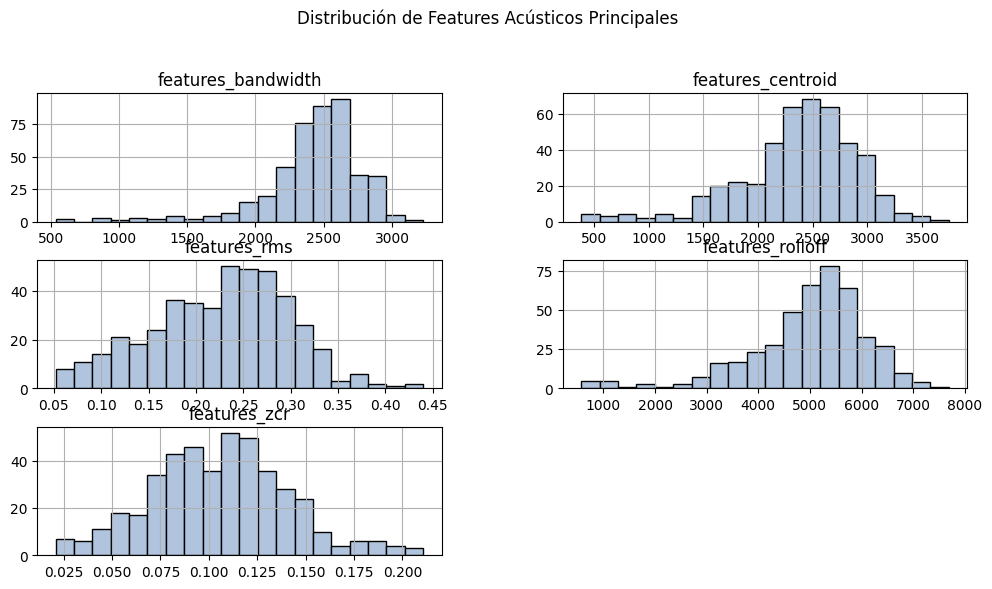

In [32]:
cols_base = [
    "features_bandwidth", "features_centroid", "features_rms",
    "features_rolloff", "features_zcr"
]

df_tracks[cols_base].hist(
    bins=20, figsize=(12, 6), color='lightsteelblue', edgecolor='black'
)
plt.suptitle("Distribución de Features Acústicos Principales", y=1.02)
plt.show()

Las distribuciones de `features_bandwidth`, `features_centroid` y `features_rolloff` presentan una forma aproximadamente normal, con concentración entre los 2.000–2.500 Hz y valores que reflejan un equilibrio entre frecuencias graves y medias. Esto sugiere que la mayoría de los fragmentos contienen timbres moderadamente brillantes, sin exceso de agudos ni predominio de frecuencias bajas.
Por su parte, `features_rms` se concentra alrededor de 0.2, indicando niveles de energía moderados y un rango dinámico controlado. Finalmente, la distribución de `features_zcr` (≈0.1) muestra que los audios poseen una combinación balanceada de sonidos armónicos y percusivos, coherente con grabaciones musicales limpias y sin ruido dominante.

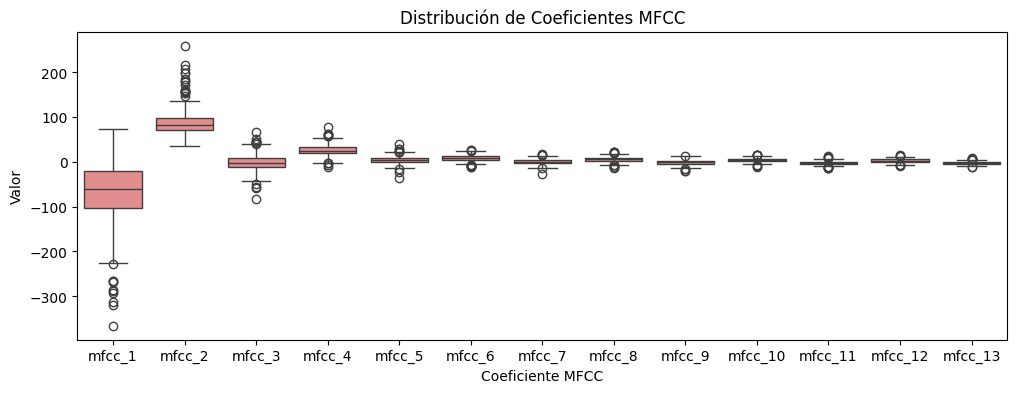

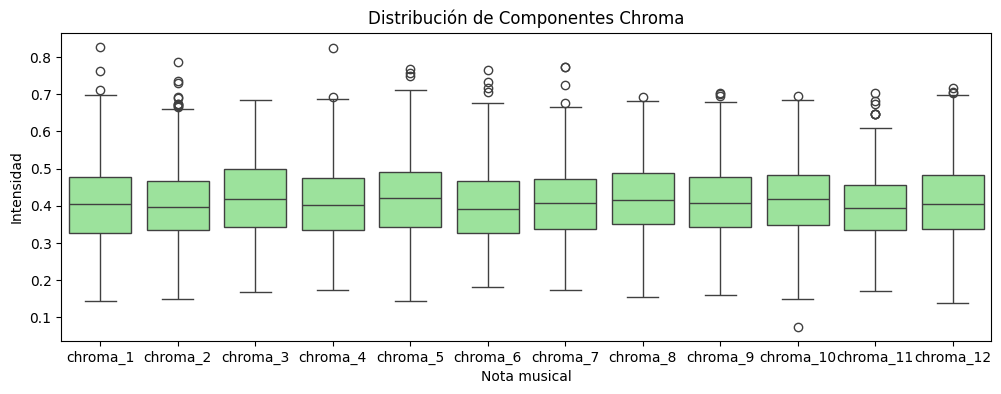

In [33]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_tracks[[c for c in df_tracks.columns if c.startswith("mfcc_")]], color="lightcoral")
plt.title("Distribución de Coeficientes MFCC")
plt.xlabel("Coeficiente MFCC")
plt.ylabel("Valor")
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(data=df_tracks[[c for c in df_tracks.columns if c.startswith("chroma_")]], color="lightgreen")
plt.title("Distribución de Componentes Chroma")
plt.xlabel("Nota musical")
plt.ylabel("Intensidad")
plt.show()

Los coeficientes MFCC muestran una clara caída desde `mfcc_1` hasta `mfcc_13`, donde el primero concentra la mayor variabilidad y amplitud de valores, reflejando diferencias significativas en la energía general y calidez del sonido entre pistas. A medida que avanzan los coeficientes, las distribuciones se estabilizan alrededor de cero, lo que sugiere consistencia tonal y una estructura espectral equilibrada sin excesiva distorsión o ruido.
En tanto, los componentes Chroma presentan una dispersión homogénea entre las doce notas musicales, con medianas cercanas a 0.45. Esto indica una distribución armónica balanceada y ausencia de dominancia tonal marcada, compatible con un corpus diverso en tonalidades e instrumentaciones.

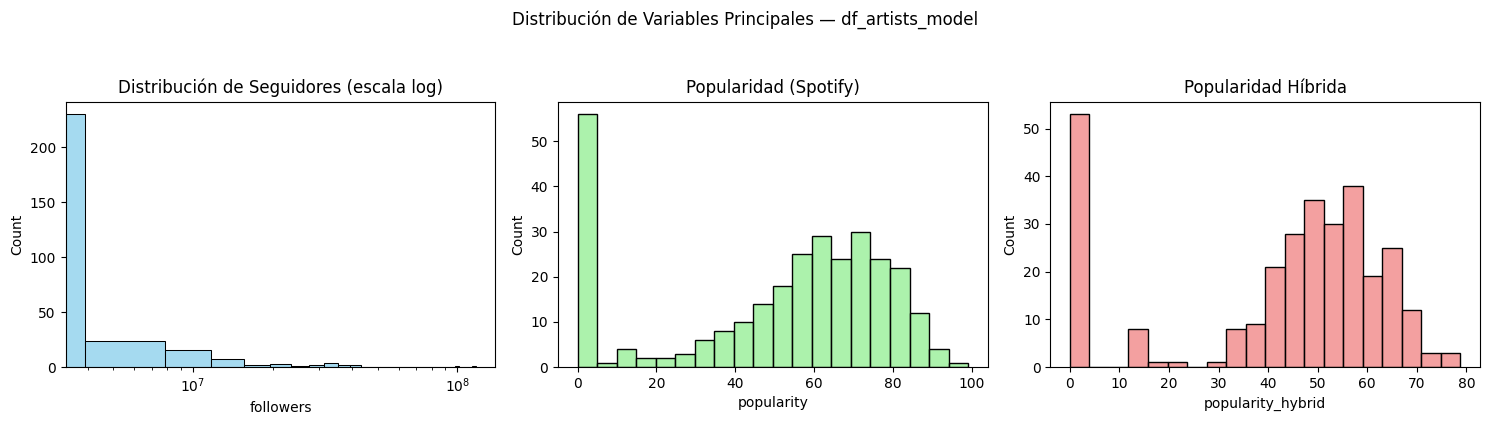

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df_artists_model['followers'], bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Distribución de Seguidores (escala log)')
axes[0].set_xscale('log')

sns.histplot(df_artists_model['popularity'], bins=20, color='lightgreen', ax=axes[1])
axes[1].set_title('Popularidad (Spotify)')

sns.histplot(df_artists_model['popularity_hybrid'], bins=20, color='lightcoral', ax=axes[2])
axes[2].set_title('Popularidad Híbrida')

plt.suptitle('Distribución de Variables Principales — df_artists_model', y=1.05)
plt.tight_layout()
plt.show()

La variable `followers` presenta una distribución altamente sesgada, incluso en escala logarítmica: la mayoría de los artistas concentra menos de un millón de seguidores, mientras que un grupo reducido alcanza valores extremadamente altos. Esto refleja la naturaleza desigual y concentrada del ecosistema musical digital, donde unos pocos concentran la visibilidad global.

En contraste, las variables popularity y popularity_hybrid muestran formas más equilibradas. La primera tiende a una distribución bimodal, con artistas tanto de baja como de alta presencia en plataformas, mientras que la popularidad híbrida se concentra entre 40 y 60 puntos, indicando una base mayoritaria de artistas con reconocimiento intermedio y actividad sostenida.

En conjunto, estos resultados evidencian una diversidad de trayectorias y niveles de exposición, coherente con un corpus que mezcla artistas consolidados, emergentes y de nicho.

C:\Users\admaz\AppData\Local\Temp\ipykernel_10752\1602095172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='mako')


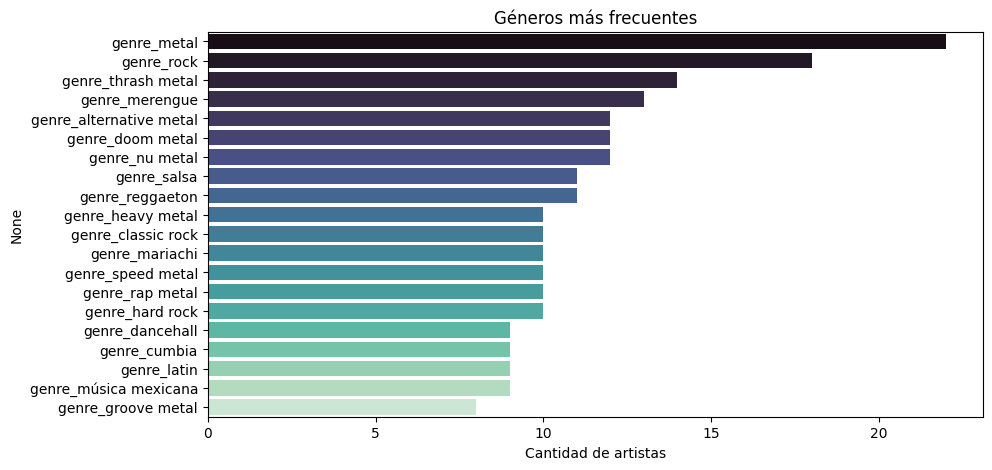

In [35]:
genre_counts = df_artists_model.filter(like='genre_').sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='mako')
plt.title('Géneros más frecuentes')
plt.xlabel('Cantidad de artistas')
plt.show()

El análisis de géneros evidencia una clara preponderancia de estilos asociados al rock y al metal, encabezados por etiquetas como metal, rock, thrash metal y alternative metal. Esta concentración refleja una identidad sonora dominante en el conjunto, orientada hacia subgéneros con alta densidad instrumental y presencia de guitarras eléctricas.

No obstante, la aparición de categorías como reggaeton, cumbia, latin y música mexicana revela una diversificación cultural progresiva, donde conviven tradiciones regionales con influencias globales.

En conjunto, la distribución sugiere que el dataset combina núcleos estilísticos potentes y de larga tradición con manifestaciones contemporáneas de música popular, reforzando su valor como muestra heterogénea de escenas musicales activas.

### 2.4 Relaciones: primeras correlaciones entre variables clave

#### a) Correlaciones en df_tracks (acústicas)

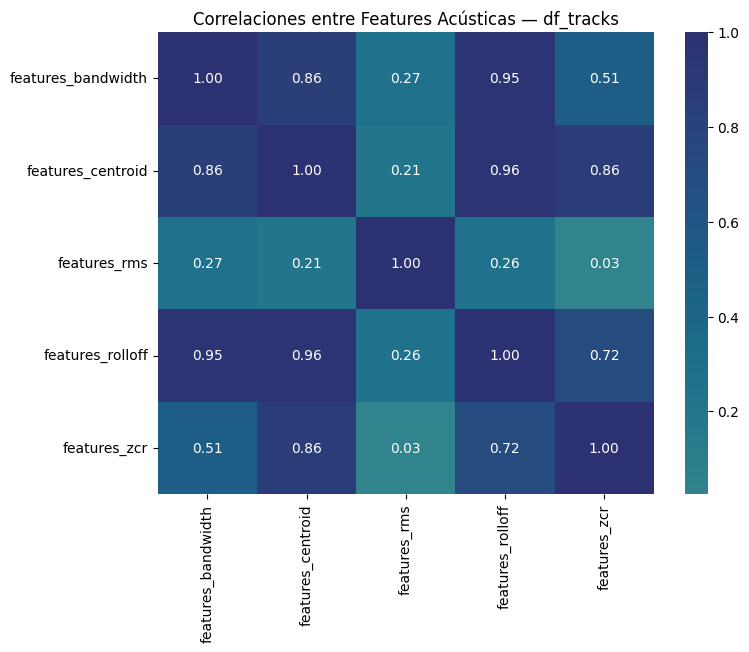

In [36]:
cols_tracks = [
    "features_bandwidth", "features_centroid", "features_rms",
    "features_rolloff", "features_zcr"
]

plt.figure(figsize=(8,6))
sns.heatmap(df_tracks[cols_tracks].corr(), annot=True, fmt=".2f", cmap="crest", center=0)
plt.title("Correlaciones entre Features Acústicas — df_tracks")
plt.show()

El análisis de correlación revela vínculos muy fuertes entre las variables `features_bandwidth`, `features_centroid` y `features_rolloff` (r > 0.85), lo que confirma que todas describen aspectos complementarios del brillo espectral y la extensión en frecuencias del sonido. En particular, la relación casi perfecta entre centroid y rolloff (r = 0.96) indica que los fragmentos con mayor contenido de frecuencias altas tienden también a presentar mayor energía en el rango agudo.

Por su parte, `features_rms` (energía promedio) muestra correlaciones débiles con el resto, lo que sugiere que el nivel de volumen o intensidad no depende directamente del timbre o del rango espectral. Finalmente, `features_zcr` mantiene asociaciones moderadas con las variables espectrales, evidenciando que la textura o aspereza sonora sí guarda cierta relación con la brillantez, pero constituye un rasgo distintivo propio.

#### b) Correlaciones en df_artists_model (popularidad y alcance)

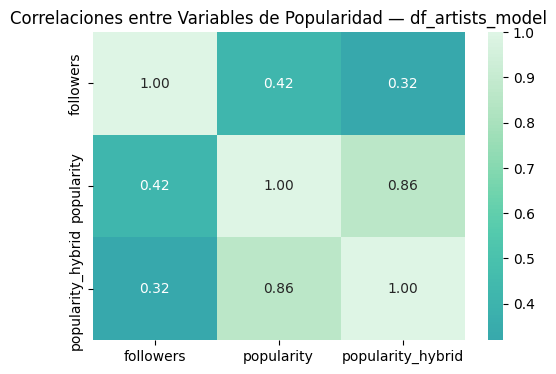

In [37]:
cols_artists = ["followers", "popularity", "popularity_hybrid"]

plt.figure(figsize=(6,4))
sns.heatmap(df_artists_model[cols_artists].corr(), annot=True, fmt=".2f", cmap="mako", center=0)
plt.title("Correlaciones entre Variables de Popularidad — df_artists_model")
plt.show()

El análisis evidencia una correlación moderada entre `followers` y `popularity` (r = 0.42), lo que sugiere que la cantidad de seguidores no siempre se traduce directamente en popularidad reciente dentro de la plataforma. En cambio, las variables `popularity` y `popularity_hybrid` muestran una asociación muy alta (r = 0.86), indicando que ambas capturan dimensiones similares del reconocimiento del artista, aunque la versión híbrida incorpora componentes más estables en el tiempo.

La correlación más débil entre `followers` y `popularity_hybrid` (r = 0.32) confirma que la visibilidad acumulada y la actividad actual son fenómenos parcialmente independientes, revelando la coexistencia de artistas con grandes comunidades pero baja reproducción reciente, y otros emergentes con alto impacto momentáneo.

El análisis exploratorio permitió identificar patrones consistentes y relaciones internas claras en ambos conjuntos de datos. En 
`df_tracks`, las features acústicas mostraron correlaciones elevadas entre sí, especialmente entre `bandwidth`, `centroid` y `rolloff`, reflejando una estructura espectral coherente y una predominancia de sonidos con brillo moderado y energía controlada. Por su parte, `df_artists_model` exhibió una distribución desigual de popularidad y seguidores, coherente con la naturaleza concentrada del ecosistema musical digital, donde unos pocos artistas acumulan gran parte de la atención. Las correlaciones entre variables sociales revelaron una conexión fuerte entre popularidad y su versión híbrida, pero solo moderada con los seguidores, evidenciando que el éxito reciente y la base acumulada de oyentes son fenómenos parcialmente independientes. En conjunto, ambas bases describen un panorama musical diverso, equilibrado y analíticamente consistente, apto para avanzar hacia la etapa de preparación y modelado.

## 3. Preparación de los datos

### 3.1 Revisión y tratamiento de valores faltantes

In [38]:
df_tracks.isnull().sum().sort_values(ascending=False)

year                  211
features_rms            9
features_centroid       9
features_bandwidth      9
features_zcr            9
mfcc_6                  9
chroma_11               9
chroma_12               9
mfcc_1                  9
mfcc_2                  9
features_rolloff        9
chroma_1                9
chroma_2                9
chroma_6                9
chroma_3                9
chroma_4                9
chroma_5                9
chroma_8                9
chroma_7                9
chroma_9                9
chroma_10               9
mfcc_10                 9
mfcc_7                  9
mfcc_8                  9
mfcc_9                  9
mfcc_12                 9
mfcc_3                  9
mfcc_4                  9
mfcc_5                  9
mfcc_13                 9
mfcc_11                 9
artist_id               3
album                   0
track_id                0
source                  0
artist_name             0
track_name              0
dtype: int64

In [39]:
df_artists_model.isnull().sum().sort_values(ascending=False)

followers            0
id                   0
listeners_lastfm     0
name                 0
popularity           0
                    ..
genre_vocal jazz     0
genre_vocaloid       0
genre_witch house    0
genre_worship        0
genre_yacht rock     0
Length: 2046, dtype: int64

La revisión de valores faltantes muestra que en df_tracks existen algunos vacíos puntuales en variables numéricas como `features_rms`, `features_centroid`, `features_bandwidth`, `features_zcr`, y varios coeficientes `mfcc` y `chroma`, todos con solo 9 valores faltantes. En paralelo, existen un número reducido de valores perdidos en `artist_id`, los cuales se van a eliminar pues la falta de identificación del artista puede generar problemas en la implementación final. Por último, la variable `year` presenta 211 registros incompletos, lo que podría estar asociado a canciones sin metadatos temporales.

Por otro lado, el dataset df_artists_model no contiene valores faltantes, lo que demuestra una estructura completa y lista para su uso en etapas posteriores.

Dado el bajo impacto de los valores ausentes en df_tracks (menos del 3 % del total de registros), se optará por imputar los valores numéricos con la media de cada columna y descartar o mantener como nulos los años faltantes, según la relevancia que adquiera la variable en el modelado.

In [40]:
# Detectar columnas con valores faltantes
cols_with_nan = df_tracks.columns[df_tracks.isnull().any()].tolist()
print("Columnas con valores faltantes:", cols_with_nan)

# Seleccionar solo columnas numéricas
numeric_cols_with_nan = [
    col for col in cols_with_nan if df_tracks[col].dtype in ['float64', 'int64']
]
print("Columnas numéricas a imputar:", numeric_cols_with_nan)

# Imputar con la media
for col in numeric_cols_with_nan:
    mean_value = df_tracks[col].mean()
    df_tracks[col].fillna(mean_value, inplace=True)

# Verificar que no queden nulos en las columnas numéricas
df_tracks[numeric_cols_with_nan].isnull().sum().sort_values(ascending=False).head(10)


Columnas con valores faltantes: ['artist_id', 'year', 'features_bandwidth', 'features_centroid', 'features_rms', 'features_rolloff', 'features_zcr', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']
Columnas numéricas a imputar: ['features_bandwidth', 'features_centroid', 'features_rms', 'features_rolloff', 'features_zcr', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']


C:\Users\admaz\AppData\Local\Temp\ipykernel_10752\2343367285.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tracks[col].fillna(mean_value, inplace=True)


features_bandwidth    0
features_centroid     0
features_rms          0
features_rolloff      0
features_zcr          0
chroma_1              0
chroma_2              0
chroma_3              0
chroma_4              0
chroma_5              0
dtype: int64

In [41]:
# Ver cuántas filas tienen artist_id nulo
df_tracks[df_tracks['artist_id'].isnull()]

# Eliminar esas filas
df_tracks = df_tracks.dropna(subset=['artist_id'])

# Verificar
df_tracks['artist_id'].isnull().sum()

np.int64(0)

Si bien no se encontraron en un primer momento nulls en en el dataframe de artistas, en la preparación de los datos fueron encontrados valores anómalos asociados a valores perdidos. En el feedback de este proceso, se va a explorar la existencia de valores perdidos de tal df

In [42]:
for col in ['followers', 'popularity', 'popularity_hybrid', 'listeners_lastfm']:
    if col in df_artists_model.columns:
        non_numeric = df_artists_model[~df_artists_model[col].apply(lambda x: isinstance(x, (int, float)))]
        if not non_numeric.empty:
            print(f"⚠️ Columna {col} contiene valores no numéricos:")
            print(non_numeric[col].unique())

⚠️ Columna listeners_lastfm contiene valores no numéricos:
['Sin datos' '62812' '109606' '21133' '51825' '362136' '18585' '28868'
 '44858' '4965293' '4342598' '4762144' '4219760' '3024540' '2905289'
 '4046838' '1840190' '3917363' '1019967' '1230497' '1307587' '2382357'
 '1949343' '2302667' '953784' '5571428' '749664' '1670786' '724041'
 '143314' '445321' '2014163' '2027580' '3862897' '5294590' '4597569'
 '1503881' '2281314' '1378357' '371645' '924759' '423960' '819816'
 '327594' '493330' '236687' '128608' '29863' '349704' '2012140' '1998462'
 '816400' '3657307' '1151816' '905015' '1770998' '207065' '470369'
 '262620' '286339' '259680' '245985' '246768' '109759' '774168' '2930087'
 '2749293' '2035354' '401971' '351647' '347238' '203610' '672060' '467389'
 '336616' '207662' '898374' '366538' '427799' '242552' '123122' '368874'
 '216695' '100287' '71873' '83095' '146314' '86949' '67942' '284475'
 '354584' '689221' '97086' '10780' '20544' '213707' '59595' '1189196'
 '166211' '347570' '2601

In [43]:
# Convertir a numérico, forzando errores a NaN
df_artists_model['listeners_lastfm'] = pd.to_numeric(
    df_artists_model['listeners_lastfm'], errors='coerce'
)

# Verificar conversión
df_artists_model['listeners_lastfm'].describe()

count    2.340000e+02
mean     1.175993e+06
std      1.481606e+06
min      2.650000e+03
25%      1.330958e+05
50%      4.688790e+05
75%      1.808613e+06
max      6.964011e+06
Name: listeners_lastfm, dtype: float64

In [44]:
df_artists_model['listeners_lastfm'] = df_artists_model['listeners_lastfm'].fillna(
    df_artists_model['listeners_lastfm'].mean()
)

In [45]:
# Verificar valores nulos en listeners_lastfm
df_artists_model['listeners_lastfm'].isnull().sum()


np.int64(0)

In [46]:
df_artists_model[['followers', 'popularity', 'popularity_hybrid', 'listeners_lastfm']].isnull().sum()

followers            0
popularity           0
popularity_hybrid    0
listeners_lastfm     0
dtype: int64

### 3.2 Normalización / Escalado de variables

In [47]:
# Definir columnas acústicas
acoustic_features = [
    'features_bandwidth', 'features_centroid', 'features_rms',
    'features_rolloff', 'features_zcr'
] + [f'chroma_{i}' for i in range(1, 13)] + [f'mfcc_{i}' for i in range(1, 14)]

# Crear DataFrame con solo las variables acústicas
df_tracks_acoustic = df_tracks[acoustic_features].copy()

In [48]:
df_tracks_acoustic = df_tracks[acoustic_features].copy()
df_tracks_acoustic.head()

,features_bandwidth,features_centroid,features_rms,features_rolloff,features_zcr,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,2762.426304,2587.620697,0.254561,5768.707689,0.078766,0.464326,0.467168,0.381047,0.460340,0.362612,...,17.975319,7.638917,11.560802,7.465429,8.956473,3.938697,11.023097,2.807900,9.193022,4.820379
1,2703.495781,2472.131194,0.245478,5566.780580,0.069721,0.540442,0.523797,0.379449,0.426516,0.397075,...,22.834686,13.501077,11.327184,8.651113,11.365549,6.950184,10.161860,1.837193,7.848457,7.090342
2,2653.328156,2552.192541,0.276433,5636.487590,0.092184,0.487763,0.411961,0.486457,0.444716,0.533455,...,22.593239,1.575805,7.987291,3.182144,14.766253,-3.503018,12.532589,2.985551,7.877229,1.501267
3,2817.581542,2905.125945,0.244931,6240.927160,0.122171,0.324312,0.347972,0.588381,0.369536,0.386946,...,27.366089,3.512032,7.901964,1.025875,-1.481319,-4.344721,6.346792,1.342260,2.585339,0.556426
4,2232.866105,2104.754785,0.239445,4368.208296,0.099745,0.338611,0.339980,0.447472,0.389582,0.431622,...,17.010540,3.009092,13.114839,-0.894076,8.382986,2.647439,6.634600,-1.268361,3.337789,-3.017822


In [49]:
# Inicializar el scaler
scaler = StandardScaler()

# Ajustar y transformar el dataset acústico
X_scaled = scaler.fit_transform(df_tracks_acoustic)

# Convertir de nuevo a DataFrame (opcional, para legibilidad)
df_tracks_scaled = pd.DataFrame(X_scaled, columns=df_tracks_acoustic.columns)

# Verificar resultado
df_tracks_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
features_bandwidth,447.0,1.057071e-15,1.00112,-5.184857,-0.346010,0.176705,0.559650,2.202808
features_centroid,447.0,4.768743e-17,1.00112,-3.732618,-0.463041,0.118912,0.646816,2.577922
features_rms,447.0,0.000000e+00,1.00112,-2.430281,-0.660580,0.134255,0.693766,2.964778
features_rolloff,447.0,-8.822175e-16,1.00112,-3.850944,-0.383766,0.163886,0.598830,2.363085
features_zcr,447.0,2.225413e-16,1.00112,-2.411756,-0.678620,0.011287,0.618425,2.979576
chroma_1,447.0,-4.450827e-16,1.00112,-2.561445,-0.763773,-0.003347,0.675392,4.048618
chroma_2,447.0,2.384372e-17,1.00112,-2.473467,-0.640604,-0.040864,0.622523,3.732001
chroma_3,447.0,-2.145934e-16,1.00112,-2.446499,-0.729220,-0.009781,0.695414,2.499243
chroma_4,447.0,1.748539e-16,1.00112,-2.231938,-0.706990,-0.078619,0.587476,3.914220
chroma_5,447.0,-3.656036e-16,1.00112,-2.616917,-0.752415,-0.027602,0.590048,3.207317


In [50]:
df_tracks_scaled.head()

,features_bandwidth,features_centroid,features_rms,features_rolloff,features_zcr,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,0.924084,0.404681,0.386754,0.684925,-0.766892,0.541243,0.623771,-0.407124,0.470050,-0.579320,...,-0.726907,0.474993,0.491959,1.351415,0.634303,1.088024,1.597056,1.249712,1.777607,2.287299
1,0.762428,0.187831,0.260503,0.508710,-1.023700,1.274631,1.176227,-0.422423,0.150706,-0.258181,...,-0.312940,1.284460,0.451889,1.580808,1.096605,1.683451,1.383629,0.971867,1.397402,3.001814
2,0.624809,0.338159,0.690746,0.569541,-0.385892,0.767068,0.085187,0.602307,0.322542,1.012628,...,-0.333509,-0.362222,-0.120976,0.522730,1.749199,-0.383343,1.971132,1.300560,1.405538,1.242544
3,1.075385,1.000849,0.252903,1.097015,0.465525,-0.807798,-0.539078,1.578357,-0.387272,-0.352568,...,0.073087,-0.094862,-0.135612,0.105559,-1.368708,-0.549763,0.438195,0.830204,-0.090859,0.945137
4,-0.528591,-0.501977,0.176650,-0.537245,-0.171235,-0.670026,-0.617038,0.228980,-0.198009,0.063728,...,-0.809096,-0.164309,0.758511,-0.265893,0.524251,0.832718,0.509518,0.082969,0.121913,-0.179928


El proceso de normalización mediante StandardScaler transformó todas las variables acústicas a una escala común (media = 0, desviación estándar = 1), eliminando diferencias de magnitud entre los distintos tipos de features (frecuencia, energía, armónicos y timbre).

Esta estandarización garantiza que los métodos de reducción de dimensionalidad —PCA y t-SNE— puedan interpretar las relaciones acústicas de manera equilibrada, sin que ninguna variable domine el espacio sonoro.


Dado que la variable `year` puede introducir tanto información contextual como sesgo temporal, se decidió evaluar dos escenarios paralelos: uno con `year` incluido en la matriz de features y otro sin él.

Este enfoque permitirá analizar si la dimensión temporal aporta información significativa al modelo o si, por el contrario, tiende a reorganizar el espacio acústico en función de la época más que de la similitud sonora.

La comparación entre ambos casos será clave para definir la estructura final del mapa musical.

Dado que la variable year puede introducir tanto información contextual como sesgo temporal, se decidió evaluar dos escenarios paralelos: uno con year incluido en la matriz de features y otro sin él.
Este enfoque permitirá analizar si la dimensión temporal aporta información significativa al modelo o si, por el contrario, tiende a reorganizar el espacio acústico en función de la época más que de la similitud sonora.
La comparación entre ambos casos será clave para definir la estructura final del mapa musical.

Con respecto al dataframe de artistas, dada la gran cantidad de variables binarias de género (más de 2000 columnas genre_*), se optó por no aplicar normalización sobre dichas columnas, conservando su representación categórica 0/1 que indica pertenencia.

El escalado se aplicó únicamente a las variables continuas (followers, popularity, popularity_hybrid y listeners_lastfm), lo que permite mantener un equilibrio entre magnitudes sociales y acústicas sin distorsionar la estructura de género.


In [51]:
df_artists_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Columns: 2046 entries, followers to genre_yacht rock
dtypes: float64(2), int64(2040), object(4)
memory usage: 4.6+ MB


In [52]:
# Variables a escalar (todas ya numéricas)
cols_to_scale = ['followers', 'popularity', 'popularity_hybrid', 'listeners_lastfm']

# Crear copia del DataFrame
df_artists_scaled = df_artists_model.copy()

# Aplicar escalado estándar (media=0, desviación=1)
scaler = StandardScaler()
df_artists_scaled[cols_to_scale] = scaler.fit_transform(df_artists_model[cols_to_scale])

# Verificar resultado
df_artists_scaled[cols_to_scale].describe().T


,count,mean,std,min,25%,50%,75%,max
followers,295.0,1.204310e-17,1.001699,-0.367836,-0.366871,-0.328896,-0.130628,10.026582
popularity,295.0,1.204310e-17,1.001699,-1.731424,-0.563478,0.295305,0.776224,1.669358
popularity_hybrid,295.0,-3.914007e-17,1.001699,-1.862604,-0.205594,0.292173,0.674900,1.623975
listeners_lastfm,295.0,2.408619e-17,1.001699,-0.891097,-0.735627,-0.168757,0.076414,4.395721


### 3.3 Preparación para fusión y modelado

Con el fin de mantener la trazabilidad entre los atributos acústicos y los metadatos originales, se concatenó la matriz escalada con las columnas identificadoras y descriptivas.

Este procedimiento garantiza que cada vector numérico pueda asociarse a su canción y artista correspondiente, facilitando la interpretación visual de los resultados de PCA y t-SNE en etapas posteriores.

In [53]:
df_tracks_acoustic.shape

(447, 30)

In [54]:
df_tracks_scaled.shape

(447, 30)

In [55]:
# Seleccionar columnas contextuales del original
cols_context = [
    'artist_id', 'artist_name', 'track_id', 'track_name', 'album', 'source', 'year'
]

# Concatenar (ejes horizontales)
df_tracks_final = pd.concat([df_tracks[cols_context].reset_index(drop=True),
                             df_tracks_scaled.reset_index(drop=True)], axis=1)

# Verificamos resultado
df_tracks_final.head(3)

,artist_id,artist_name,track_id,track_name,album,source,year,features_bandwidth,features_centroid,features_rms,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.924084,0.404681,0.386754,...,-0.726907,0.474993,0.491959,1.351415,0.634303,1.088024,1.597056,1.249712,1.777607,2.287299
1,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.762428,0.187831,0.260503,...,-0.312940,1.284460,0.451889,1.580808,1.096605,1.683451,1.383629,0.971867,1.397402,3.001814
2,0QaEZDGc6KJmdHCgRbOWRe,Verjal Fresh Kutt,7sNn28V5xNQrrvuzcMx71N,Wet Pan Dey,Wet Pan Dey,spotify,2022,0.624809,0.338159,0.690746,...,-0.333509,-0.362222,-0.120976,0.522730,1.749199,-0.383343,1.971132,1.300560,1.405538,1.242544


df_artists_scaled En el siguiente paso, se aplicará una solución similar a la anterior para generar un dataframe de artistas para el análisis.

In [56]:
df_artists_model.shape

(295, 2046)

In [57]:
df_artists_scaled.shape

(295, 2046)

In [58]:
# Mantener el DataFrame escalado como base final
df_artists_final = df_artists_scaled.copy()

# Verificar que las columnas estén correctas
df_artists_final[['followers', 'popularity', 'popularity_hybrid', 'listeners_lastfm']].describe().T.head()


,count,mean,std,min,25%,50%,75%,max
followers,295.0,1.204310e-17,1.001699,-0.367836,-0.366871,-0.328896,-0.130628,10.026582
popularity,295.0,1.204310e-17,1.001699,-1.731424,-0.563478,0.295305,0.776224,1.669358
popularity_hybrid,295.0,-3.914007e-17,1.001699,-1.862604,-0.205594,0.292173,0.674900,1.623975
listeners_lastfm,295.0,2.408619e-17,1.001699,-0.891097,-0.735627,-0.168757,0.076414,4.395721


In [59]:
genre_cols = [c for c in df_artists_final.columns if c.startswith('genre_')]
df_artists_final[genre_cols].sum().sort_values(ascending=False).head(5)

genre_metal                22
genre_rock                 18
genre_thrash metal         14
genre_merengue             13
genre_alternative metal    12
dtype: int64

Tras la estandarización, las columnas normalizadas fueron reintegradas al conjunto completo de artistas, preservando las variables categóricas binarias (`genre_*`) y los identificadores textuales.

El resultado, df_artists_final, constituye la versión definitiva del dataset de artistas: una matriz híbrida que combina dimensiones sociales escaladas y una representación semántica amplia de géneros, lista para análisis conjuntos con las dimensiones acústicas de los tracks.

La unión entre df_tracks_final (características acústicas) y df_artists_final (atributos sociales y de género) se realizará utilizando la clave común 
`artist_id`.

Se empleó una unión interna para asegurar la correspondencia exacta entre artistas presentes en ambos conjuntos, preservando así la coherencia analítica.

El nuevo DataFrame resultante constituye una matriz híbrida de información musical, que integra timbre, energía, tonalidad, popularidad y pertenencia genérica.

Esta estructura permitirá analizar relaciones cruzadas entre sonido y contexto social, así como aplicar modelos de reducción de dimensionalidad (PCA y t-SNE) con un enfoque holístico del paisaje musical.

In [60]:
df_tracks_final['artist_id'].nunique(), df_artists_final['id'].nunique() if 'id' in df_artists_final.columns else df_artists_final['artist_id'].nunique()

(284, 285)

Lo anterior significa que hay solo un artista en df_artists_final que no tiene ningún track asociado en df_tracks_final, o viceversa. Es una diferencia insignificante (menos del 0.4 %), y no afecta el análisis. En definitiva, confirma que la relación entre los datasets es casi 1:1, lo cual valida el uso de una unión interna (inner join) sin riesgo de perder información relevante.

In [61]:
# Renombrar si es necesario
if 'id' in df_artists_final.columns:
    df_artists_final.rename(columns={'id': 'artist_id'}, inplace=True)

# Verificar
'artist_id' in df_artists_final.columns

True

In [62]:
df_merge = pd.merge(
    df_tracks_final,
    df_artists_final,
    on='artist_id',
    how='inner'
)

# Confirmar dimensiones
df_merge.shape

(473, 2082)

In [63]:
# Revisión de coincidencias por artista
df_merge['artist_name'].nunique(), df_merge['artist_id'].nunique()

(292, 284)

In [64]:
df_merge.groupby('artist_id')['track_name'].nunique().describe()

count    284.000000
mean       1.563380
std        0.905147
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        4.000000
Name: track_name, dtype: float64

El análisis de la integración final mostró 292 nombres de artista distintos asociados a 284 identificadores únicos, lo que indica la presencia de colaboraciones o alias que comparten el mismo artist_id.

Esta situación es esperable en bases musicales, donde un mismo artista puede participar en varios tracks o figurar bajo distintas denominaciones.
La validación confirma que la correspondencia entre canciones y artistas es consistente, garantizando que el dataset combinado preserve tanto la diversidad musical como la integridad referencial necesaria para los análisis posteriores.

In [65]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Columns: 2082 entries, artist_id to genre_yacht rock
dtypes: float64(34), int64(2038), object(10)
memory usage: 7.5+ MB


In [66]:
df_merge.head()

,artist_id,artist_name,track_id,track_name,album,source,year,features_bandwidth,features_centroid,features_rms,...,genre_tropical music,genre_turreo,genre_urbano latino,genre_vallenato,genre_vaporwave,genre_vocal jazz,genre_vocaloid,genre_witch house,genre_worship,genre_yacht rock
0,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.924084,0.404681,0.386754,...,0,0,0,0,0,0,0,0,0,0
1,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.762428,0.187831,0.260503,...,0,0,0,0,0,0,0,0,0,0
2,0QaEZDGc6KJmdHCgRbOWRe,Verjal Fresh Kutt,7sNn28V5xNQrrvuzcMx71N,Wet Pan Dey,Wet Pan Dey,spotify,2022,0.624809,0.338159,0.690746,...,0,0,0,0,0,0,0,0,0,0
3,7gQr0u81fnZ56en4MmxHD5,Lil Flama x Flee,eOh1oCTVQ6s,Mother Place (feat. Lil Flama x Flee),Justice League Riddim,youtube,None,1.075385,1.000849,0.252903,...,0,0,0,0,0,0,0,0,0,0
4,2mw8EmDO0SWOHF5Nu8j2Lq,The Grinning Ghosts,5IPOJjWTtF8O06YPW6bgZ7,Minnie's Yoo Hoo,EP 2,spotify,2018,-0.528591,-0.501977,0.176650,...,0,0,0,0,0,0,0,0,0,0


Antes de aplicar los modelos de reducción de dimensionalidad, se detectó la presencia de múltiples registros por artista, correspondientes a diferentes canciones asociadas a un mismo `artist_id`.

Dado que el objetivo del análisis es representar el espacio musical a nivel de artistas, se consolidaron los registros mediante la media de sus variables numéricas, generando una única observación representativa por artista.

Este proceso elimina redundancias y garantiza una representación equilibrada de cada creador en el modelo.

Además, con el fin de preservar la trazabilidad y evitar modificaciones sobre el dataset combinado original (df_merge), se generó una versión derivada (df_merge_clean) destinada exclusivamente al modelamiento.

Esta estrategia mantiene la integridad del conjunto inicial y habilita el análisis jerárquico del proyecto miNoise en dos niveles: artistas y géneros.

In [67]:
# Crear copia de seguridad del merge original
df_merge_original = df_merge.copy()

# Crear copia de trabajo limpia para operaciones posteriores
df_merge_clean = df_merge.copy()

In [68]:
df_merge_clean.head()


,artist_id,artist_name,track_id,track_name,album,source,year,features_bandwidth,features_centroid,features_rms,...,genre_tropical music,genre_turreo,genre_urbano latino,genre_vallenato,genre_vaporwave,genre_vocal jazz,genre_vocaloid,genre_witch house,genre_worship,genre_yacht rock
0,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.924084,0.404681,0.386754,...,0,0,0,0,0,0,0,0,0,0
1,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.762428,0.187831,0.260503,...,0,0,0,0,0,0,0,0,0,0
2,0QaEZDGc6KJmdHCgRbOWRe,Verjal Fresh Kutt,7sNn28V5xNQrrvuzcMx71N,Wet Pan Dey,Wet Pan Dey,spotify,2022,0.624809,0.338159,0.690746,...,0,0,0,0,0,0,0,0,0,0
3,7gQr0u81fnZ56en4MmxHD5,Lil Flama x Flee,eOh1oCTVQ6s,Mother Place (feat. Lil Flama x Flee),Justice League Riddim,youtube,None,1.075385,1.000849,0.252903,...,0,0,0,0,0,0,0,0,0,0
4,2mw8EmDO0SWOHF5Nu8j2Lq,The Grinning Ghosts,5IPOJjWTtF8O06YPW6bgZ7,Minnie's Yoo Hoo,EP 2,spotify,2018,-0.528591,-0.501977,0.176650,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Variables numéricas a promediar (todas las features)
numeric_cols = df_merge_clean.select_dtypes(include=[np.number]).columns

# Calcular promedios por artista
df_artist_means = (
    df_merge_clean.groupby('artist_id')[numeric_cols]
    .mean()
    .add_prefix('artist_')  # prefijo para distinguirlas
    .reset_index()
)

In [70]:
df_merge_clean = pd.merge(
    df_merge_clean,
    df_artist_means,
    on='artist_id',
    how='left'
)

In [71]:
df_merge_clean.head()

,artist_id,artist_name,track_id,track_name,album,source,year,features_bandwidth,features_centroid,features_rms,...,artist_genre_tropical music,artist_genre_turreo,artist_genre_urbano latino,artist_genre_vallenato,artist_genre_vaporwave,artist_genre_vocal jazz,artist_genre_vocaloid,artist_genre_witch house,artist_genre_worship,artist_genre_yacht rock
0,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.924084,0.404681,0.386754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.762428,0.187831,0.260503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0QaEZDGc6KJmdHCgRbOWRe,Verjal Fresh Kutt,7sNn28V5xNQrrvuzcMx71N,Wet Pan Dey,Wet Pan Dey,spotify,2022,0.624809,0.338159,0.690746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7gQr0u81fnZ56en4MmxHD5,Lil Flama x Flee,eOh1oCTVQ6s,Mother Place (feat. Lil Flama x Flee),Justice League Riddim,youtube,None,1.075385,1.000849,0.252903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2mw8EmDO0SWOHF5Nu8j2Lq,The Grinning Ghosts,5IPOJjWTtF8O06YPW6bgZ7,Minnie's Yoo Hoo,EP 2,spotify,2018,-0.528591,-0.501977,0.176650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Contar cuántas filas por artista y track
df_merge_clean.groupby(['artist_name', 'track_name']).size().sort_values(ascending=False).head


<bound method NDFrame.head of artist_name                            track_name                    
Nusrat Fateh Ali Khan                  Ali ali ali maula ali ali, haq    3
Nusrat Fateh Ali Khan & Michael Brook  Longing                           3
Nusrat Fateh Ali Khan & Party          Yeh Jo Halka Saroor Hae           3
DLG                                    Pitso Yaka                        2
                                       Semphete                          2
                                                                        ..
Atlantic Wiz                           Iced Out Necklace                 1
Ayesha Erotica                         Emo Boy                           1
                                       Yummy                             1
                                       Yummy - Righteous Remix           1
AC/DC                                  Thunderstruck                     1
Length: 447, dtype: int64>

In [73]:
df_merge_clean = df_merge_clean.drop_duplicates(subset=['artist_id', 'track_name'], keep='first').reset_index(drop=True)

In [74]:
df_merge_clean.head()

,artist_id,artist_name,track_id,track_name,album,source,year,features_bandwidth,features_centroid,features_rms,...,artist_genre_tropical music,artist_genre_turreo,artist_genre_urbano latino,artist_genre_vallenato,artist_genre_vaporwave,artist_genre_vocal jazz,artist_genre_vocaloid,artist_genre_witch house,artist_genre_worship,artist_genre_yacht rock
0,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,49S1dSV2audIsxvOJ76Q2C,Turn It Around - Tribute to Sub Focus and Kele,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.924084,0.404681,0.386754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0GzaI3hZcuFafv2RGvfnPA,Turn It Around,69uJ2jEoba3ROesZV7st3x,Turn It Around - Tribute to Sub Focus and Kele...,Turn It Around - Tribute to Sub Focus and Kele,spotify,2013,0.762428,0.187831,0.260503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0QaEZDGc6KJmdHCgRbOWRe,Verjal Fresh Kutt,7sNn28V5xNQrrvuzcMx71N,Wet Pan Dey,Wet Pan Dey,spotify,2022,0.624809,0.338159,0.690746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7gQr0u81fnZ56en4MmxHD5,Lil Flama x Flee,eOh1oCTVQ6s,Mother Place (feat. Lil Flama x Flee),Justice League Riddim,youtube,None,1.075385,1.000849,0.252903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2mw8EmDO0SWOHF5Nu8j2Lq,The Grinning Ghosts,5IPOJjWTtF8O06YPW6bgZ7,Minnie's Yoo Hoo,EP 2,spotify,2018,-0.528591,-0.501977,0.176650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
df_merge_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Columns: 4154 entries, artist_id to artist_genre_yacht rock
dtypes: float64(2106), int64(2038), object(10)
memory usage: 14.1+ MB


In [76]:
df_merge_clean.groupby(['artist_name', 'track_name']).size().sort_values(ascending=False).head


<bound method NDFrame.head of artist_name      track_name     
26is             Choreando          1
A Global Threat  Religious Scam     1
AC/DC            Back In Black      1
                 Highway to Hell    1
                 Thunderstruck      1
                                   ..
Zero 7           Today              1
bôa              Duvet              1
overthrash       Overthrash         1
Куба             Куба               1
楊美娜              HOW DO I           1
Length: 444, dtype: int64>

Durante la depuración final se identificaron registros con artistas y títulos coincidentes, pero asociados a distintos identificadores de track o fuentes.

Estas diferencias reflejan versiones, remixes o reediciones que aportan variabilidad acústica relevante para el análisis.

Por esta razón, se decidió mantener todas las instancias de canciones por artista, conservando así la riqueza sonora y la diversidad representativa del catálogo musical dentro del modelo.

La capa de géneros se construyó promediando las variables numéricas de los artistas que pertenecen a cada género binario del dataset.

Cada fila representa el centro acústico y social de un género, sintetizando el comportamiento promedio de sus artistas.

Este procedimiento permite representar los géneros como entidades agregadas en el espacio sonoro, facilitando la comparación y visualización global de la diversidad musical.

In [77]:
# Detectar columnas binarias de género
genre_cols = [col for col in df_merge_clean.columns if col.startswith('genre_')]
print(f"{len(genre_cols)} columnas de género detectadas")


192 columnas de género detectadas


In [78]:
# Seleccionar solo las columnas numéricas relevantes
numeric_cols = df_merge_clean.select_dtypes(include=[np.number]).columns

# Crear lista con variables acústicas y sociales que quieras promediar por género
cols_to_average = [c for c in numeric_cols if not c.startswith('genre_')]

# Crear lista donde almacenar resultados
genre_layers = []

# Iterar sobre cada género y calcular promedios
for genre in genre_cols:
    subset = df_merge_clean[df_merge_clean[genre] == 1]
    if not subset.empty:
        mean_values = subset[cols_to_average].mean()
        mean_values['genre_name'] = genre.replace('genre_', '')
        mean_values['n_artists'] = subset['artist_id'].nunique()
        genre_layers.append(mean_values)

# Convertir lista en DataFrame final
df_genres_layer = pd.DataFrame(genre_layers)

In [79]:
df_genres_layer.head()


,features_bandwidth,features_centroid,features_rms,features_rolloff,features_zcr,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,...,artist_genre_urbano latino,artist_genre_vallenato,artist_genre_vaporwave,artist_genre_vocal jazz,artist_genre_vocaloid,artist_genre_witch house,artist_genre_worship,artist_genre_yacht rock,genre_name,n_artists
0,0.007040,-0.254551,-0.113395,-0.079423,-0.464200,0.937004,0.242539,-0.382871,-0.378849,-0.924515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acid jazz,2
1,-0.018755,-0.100782,-0.782269,-0.051230,-0.066863,-0.564481,-0.482950,-0.176529,-0.259716,0.315903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acid rock,4
2,-0.241938,-0.755806,-0.491193,-0.722718,-0.925513,-1.516385,-1.249426,-1.525460,-0.201625,-0.841864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,acoustic pop,1
3,1.165609,0.186772,-0.377577,0.826937,-0.496628,-0.895520,-0.165928,-0.232882,-0.265145,-0.531205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,african gospel,1
4,0.066623,-0.311168,0.818907,-0.102697,-1.087646,-0.122236,-0.459346,0.136162,-1.061318,-0.831785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,afrobeats,1


El proyecto se organiza en tres niveles jerárquicos que representan distintas escalas del análisis musical:  

desde las características acústicas individuales de cada **track**, hasta los promedios agregados por **artista** y finalmente por **género**.  
Esta estructura permite analizar la música tanto en su dimensión micro (canción) como macro (escenas y estilos), reflejando el principio de *EveryNoise*.

__Niveles del Modelo:__

| Nivel | Unidad de Análisis | Descripción | Ejemplo de Variables | Fuente / DataFrame |
|:------:|--------------------|--------------|-----------------------|--------------------|
| **1** | 🎧 *Track* | Representa las características acústicas individuales de cada canción. | `features_rms`, `features_centroid`, `chroma_*`, `mfcc_*` | `df_merge_clean` |
| **2** | 👤 *Artista* | Promedio de las variables acústicas y sociales de todas las canciones de un artista. | `artist_features_centroid`, `artist_popularity`, `artist_followers` | `df_merge_clean` (capas agregadas con prefijo `artist_`) |
| **3** | 🎼 *Género* | Promedio de las variables de todos los artistas que pertenecen a un mismo género binario. | `artist_*`, `genre_*` (valores medios por grupo) | `df_genres_layer` |

- **Nivel 1 – Tracks:** captura la variabilidad sonora entre canciones, útil para analizar la dispersión acústica dentro de un mismo artista o género.  
- **Nivel 2 – Artistas:** sintetiza el perfil medio de cada creador, representando su “centro” acústico y social.  
- **Nivel 3 – Géneros:** consolida el comportamiento promedio de los artistas por género, generando el mapa global del espacio sonoro.

> Esta jerarquía posibilita una lectura *multinivel* del panorama musical:  
>   desde las microvariaciones tímbricas hasta los patrones culturales agregados por escena o estilo.


## 4. Modelamiento

### 4.1 Selección de modelos

El objetivo de esta fase es representar el espacio sonoro y social del proyecto *miNoise* en una forma visual y analítica. Para ello, se seleccionan dos modelos de reducción de dimensionalidad:

1. **PCA (Análisis de Componentes Principales):** permite identificar las dimensiones acústicas dominantes y representar los datos en 2 o 3 componentes principales.  
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding):** enfatiza las similitudes locales entre canciones o artistas, revelando agrupaciones naturales de estilo.

Estos modelos se aplicarán sobre las tres capas del proyecto (tracks, artistas y géneros) a fin de comparar sus estructuras y observar cómo emergen los patrones sonoros a distintas escalas.



| Modelo                                                  | Tipo                      | Propósito                                                                                   | Características                                                                                               |
| :------------------------------------------------------ | :------------------------ | :------------------------------------------------------------------------------------------ | :------------------------------------------------------------------------------------------------------------ |
| **PCA (Principal Component Analysis)**                  | Lineal, no supervisado    | Identificar las dimensiones acústicas dominantes y representar el espacio musical en 2D/3D. | Proyecta los datos en componentes ortogonales que maximizan la varianza. Ideal para ver estructuras globales. |
| **t-SNE (t-Distributed Stochastic Neighbor Embedding)** | No lineal, no supervisado | Visualizar similitudes locales entre canciones, artistas o géneros.                         | Preserva las distancias entre puntos cercanos, revelando “clusters” naturales de estilo.                      |


El propósito del empleo de estos modelos indicados es reducir la dimensionalidad de los datos para representar el espacio musical en una forma interpretable, permitiendo observar relaciones entre canciones, artistas y géneros.

### 4.2 Selección de variables

Para después

### 4.3 Diseños de testeo de modelos

#### Modelamiento: PCA

El objetivo de la aplicación de este modelo es reducir la dimensionalidad de los datos agregados en los niveles de Artista y Género mediante el método PCA (Análisis de Componentes Principales), con el fin de representar el espacio sonoro y social de la música en un plano visual interpretable.

Dado que el tablero final del proyecto *miNoise* será tridimensional, el modelo PCA se ajustó con **tres componentes principales**. Esto permite conservar una mayor proporción de la varianza total y proyectar los datos en un espacio 3D interactivo, facilitando la exploración visual del universo musical.

En esta etapa se aplicó un análisis PCA sobre el DataFrame df_genres_layer, representando cada género musical como un centroide acústico-social dentro del espacio tridimensional definido por las variables estandarizadas. Este modelo permite construir el “mapa global de géneros”, donde la posición de cada punto refleja similitud sonora y social entre estilos. 

Luego, se incorporó la columna `main_genre` en df_merge_clean, identificando el género predominante de cada artista a partir de las columnas binarias `artist_genre_*`. Esta vinculación permite conectar coherentemente los niveles jerárquicos del sistema —Género → Artistas → Tracks—, habilitando una navegación visual y analítica dentro del mismo espacio PCA.

In [80]:
# Asegurar columnas numéricas
numeric_cols = df_genres_layer.select_dtypes("number").columns.tolist()
if "n_artists" in numeric_cols:
    numeric_cols.remove("n_artists")

# PCA de géneros (3D)
pca_genres = PCA(n_components=3, random_state=42)
X_genres_pca = pca_genres.fit_transform(df_genres_layer[numeric_cols])

df_genres_layer["PC1"] = X_genres_pca[:, 0]
df_genres_layer["PC2"] = X_genres_pca[:, 1]
df_genres_layer["PC3"] = X_genres_pca[:, 2]

print(f"PCA géneros completado (varianza explicada: {pca_genres.explained_variance_ratio_.sum():.2%})")


PCA géneros completado (varianza explicada: 40.73%)


El análisis de componentes principales aplicado a los centroides de género explicó un 40,73% de la varianza total. Este valor indica que las tres primeras componentes capturan una proporción significativa de la variabilidad acústica y social entre géneros, permitiendo representar de forma reducida y coherente las relaciones estilísticas dentro del espacio sonoro global.

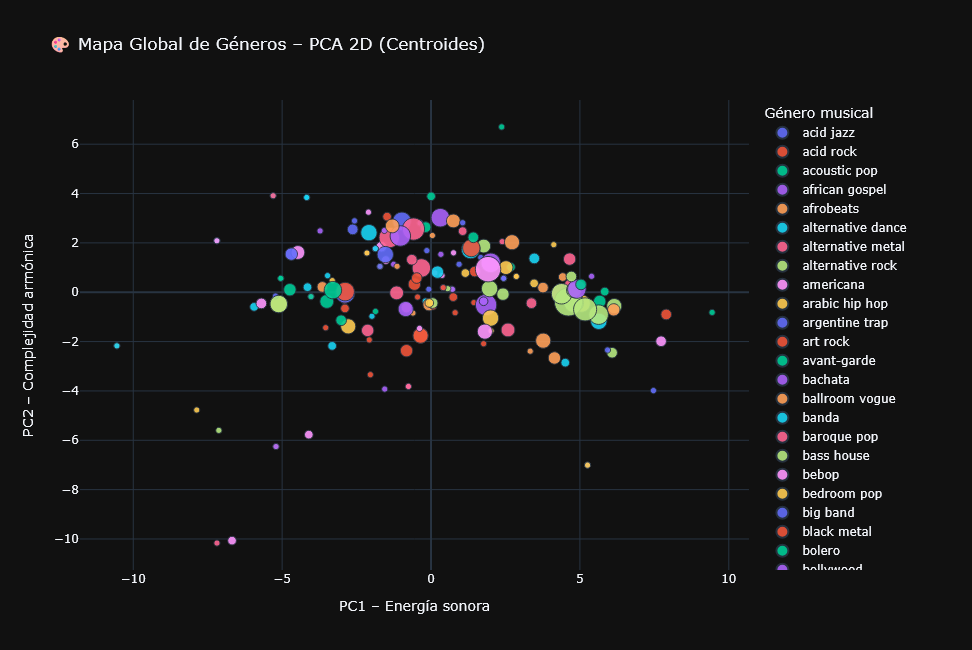

In [81]:
fig2d_genres = px.scatter(
    df_genres_layer,
    x="PC1",
    y="PC2",
    color="genre_name",
    size="n_artists",
    hover_name="genre_name",
    title="🎨 Mapa Global de Géneros – PCA 2D (Centroides)",
    opacity=0.9,
    width=900,
    height=650
)

fig2d_genres.update_layout(
    xaxis_title="PC1 – Energía sonora",
    yaxis_title="PC2 – Complejidad armónica",
    legend_title_text="Género musical",
    template="plotly_dark"
)

fig2d_genres.show()

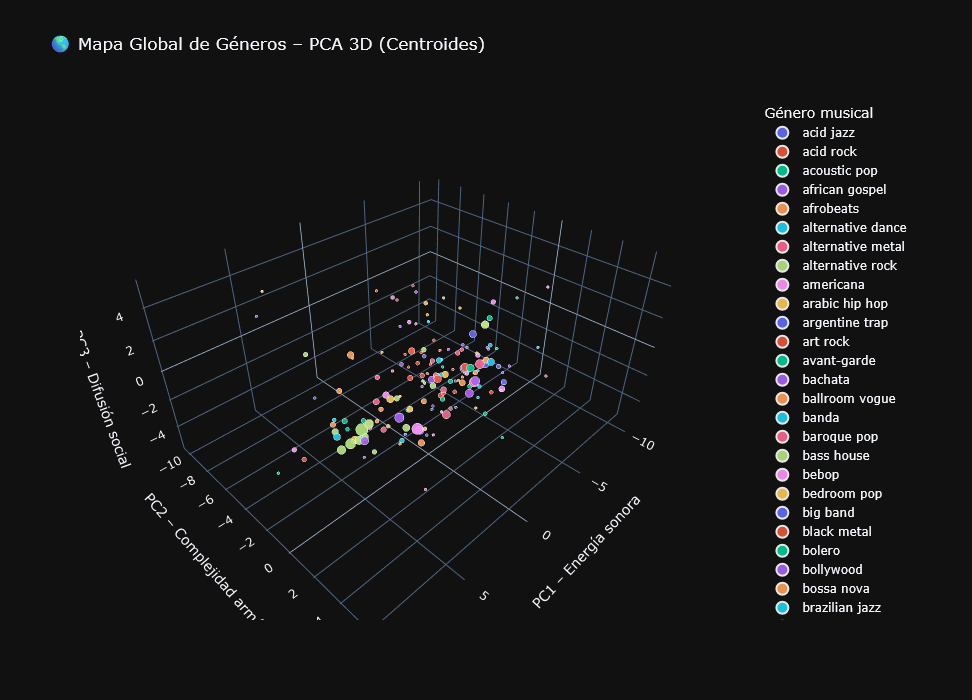

In [82]:
fig = px.scatter_3d(
    df_genres_layer,
    x="PC1",
    y="PC2",
    z="PC3",
    color="genre_name",
    size="n_artists",
    hover_name="genre_name",
    title="🌎 Mapa Global de Géneros – PCA 3D (Centroides)",
    opacity=0.9,
    width=950,
    height=700
)

fig.update_layout(
    scene=dict(
        xaxis_title="PC1 – Energía sonora",
        yaxis_title="PC2 – Complejidad armónica",
        zaxis_title="PC3 – Difusión social"
    ),
    legend_title_text="Género musical",
    template="plotly_dark"
)

fig.show()


Tras los resultados obtenidos en el modelamiento PCA de géneros, se procedió a extender el mismo enfoque al nivel de artistas individuales.

En este punto del proceso, el dataset df_merge_clean contiene una gran cantidad de columnas binarias asociadas a géneros musicales.
Estas variables (`genre_*` y `artist_genre_*`) fueron generadas anteriormente para disgregar los anidados del dataset original, y cada una indica si un artista o canción pertenece o no a un género determinado (valor 1 o 0).

En total, el conjunto incluye centenares de columnas que abarcan desde categorías amplias como rock o pop hasta subgéneros muy específicos como acid jazz, neo-psychedelic o witch house.

Esta estructura dispersa y redundante introduce varios desafíos analíticos:

1. Alta dimensionalidad: la existencia de más de 300 variables binarias genera una matriz extremadamente amplia y escasamente poblada, dificultando la detección de patrones globales.

2. Multicolinealidad semántica: muchos géneros son combinaciones o sinónimos entre sí (latin pop, pop latino, latin dance), lo que puede producir correlaciones artificiales.

3. Escala de pertenencia desigual: algunos géneros tienen cientos de artistas asociados, mientras otros solo cuentan con uno o dos, generando sesgos en los modelos basados en distancia.

Por estas razones, antes de aplicar cualquier técnica de reducción de dimensionalidad (como PCA o UMAP), es necesario regularizar este conjunto de variables.

El objetivo de esta regularización no es eliminar la diversidad genérica, sino concentrarla en una representación más compacta y significativa, donde cada artista pueda describirse a partir de un número reducido de dimensiones que capturen su afinidad hacia distintos estilos.

Este proceso constituye el paso previo a la construcción del espacio probabilístico de géneros, en el cual las relaciones binarias se transformarán en distribuciones continuas de pertenencia, reflejando mejor la naturaleza híbrida y difusa de la identidad sonora de los artistas contemporáneos.

In [83]:
# Seleccionar las columnas acústicas
acoustic_cols = [c for c in df_merge_clean.columns 
                 if c.startswith(("features_", "chroma_", "mfcc_"))]

print(f"Columnas acústicas detectadas: {len(acoustic_cols)}")

# Escalar los datos acústicos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merge_clean[acoustic_cols])

# Aplicar PCA 3D
pca_artists = PCA(n_components=3, random_state=42)
X_pca = pca_artists.fit_transform(X_scaled)

# Guardar resultados en el dataframe
df_merge_clean["PC1"] = X_pca[:, 0]
df_merge_clean["PC2"] = X_pca[:, 1]
df_merge_clean["PC3"] = X_pca[:, 2]

print(f" Varianza explicada total (artistas): {pca_artists.explained_variance_ratio_.sum():.2%}")
print(df_merge_clean[["PC1", "PC2", "PC3"]].head())

Columnas acústicas detectadas: 30
 Varianza explicada total (artistas): 51.87%
        PC1       PC2       PC3
0  2.042058 -0.165127  3.780307
1  2.932777 -1.414290  3.720347
2  2.661119  0.077396  1.814943
3  1.157633  1.590777  0.414027
4 -0.171737 -0.285668  0.124163


El análisis PCA permitió condensar las 30 variables acústicas en tres componentes principales (`PC1–PC3`) que explican el 51,87 % de la variabilidad total. Esto genera un espacio tridimensional donde cada artista se ubica según su perfil sonoro, revelando patrones de energía, timbre y textura comunes entre ellos. Este paso reduce la complejidad del dataset y sienta la base para comparar artistas y géneros en términos de proximidad acústica, en lugar de etiquetas categóricas.

In [84]:
# Espacios PCA de artistas y géneros
X_artists = df_merge_clean[["PC1", "PC2", "PC3"]].values
X_genres = df_genres_layer[["PC1", "PC2", "PC3"]].values
genre_names = df_genres_layer["genre_name"].values

# Calcular distancias y similitudes
distances = cdist(X_artists, X_genres, metric="euclidean")
similarities = 1 / (1 + distances)

# Convertir similitudes en probabilidades
probabilities = similarities / similarities.sum(axis=1, keepdims=True)

# Crear el DataFrame con las nuevas columnas prob_*
df_prob = pd.DataFrame(probabilities, columns=[f"prob_{g}" for g in genre_names])
df_prob["artist_name"] = df_merge_clean["artist_name"].values

# Unir al dataset principal
df_merge_clean = df_merge_clean.merge(df_prob, on="artist_name", how="left")

print(f"Columnas prob_ agregadas: {len([c for c in df_merge_clean.columns if c.startswith('prob_')])}")
print("Afinidades probabilísticas calculadas correctamente.")

Columnas prob_ agregadas: 192
Afinidades probabilísticas calculadas correctamente.


El cálculo de afinidades probabilísticas generó 192 variables `prob_*`, que representan la proximidad acústica de cada artista respecto a los centroides de los géneros. Estas probabilidades sustituyen la pertenencia binaria tradicional, permitiendo observar grados de relación y mixtura entre estilos. El resultado ofrece una representación más continua y realista del panorama musical, donde los artistas pueden situarse entre varios géneros según su perfil sonoro.

In [85]:
# Seleccionar las columnas prob_*
prob_cols = [c for c in df_merge_clean.columns if c.startswith("prob_")]

# Escalar los datos de afinidades
scaler = StandardScaler()
X_prob_scaled = scaler.fit_transform(df_merge_clean[prob_cols])

# Aplicar PCA con 5 componentes
pca_emb = PCA(n_components=5, random_state=42)
X_emb = pca_emb.fit_transform(X_prob_scaled)

# Agregar las nuevas columnas al dataframe
for i in range(5):
    df_merge_clean[f"emb_{i+1}"] = X_emb[:, i]

print(f"Varianza explicada total (embeddings): {pca_emb.explained_variance_ratio_.sum():.2%}")
print(df_merge_clean[[f'emb_{i+1}' for i in range(5)]].head())

Varianza explicada total (embeddings): 79.41%
      emb_1     emb_2     emb_3     emb_4     emb_5
0  2.285575  3.923383  9.274537 -2.824879  1.648508
1  4.720018  0.270684  9.675204 -2.734273  1.525477
2  2.285575  3.923383  9.274537 -2.824879  1.648508
3  4.720018  0.270684  9.675204 -2.734273  1.525477
4  6.662813  3.707514  5.257144 -1.186912  0.533233


La reducción PCA aplicada sobre las 192 afinidades probabilísticas generó cinco componentes principales (`emb_1–5`), que condensan la mayor parte de la estructura latente del espacio de géneros.

El segundo análisis PCA aplicado sobre las 192 variables de afinidad (`prob_*`) logró condensar el espacio de géneros en cinco componentes (`emb_1–emb_5`), que explican el 79,41 % de la varianza total. Este resultado demuestra una alta compresibilidad del modelo, conservando las relaciones principales entre artistas y géneros. 

In [86]:
# Seleccionar las columnas de probabilidad
prob_cols = [c for c in df_merge_clean.columns if c.startswith("prob_")]

# Determinar el índice de la probabilidad más alta en cada fila
max_prob_idx = df_merge_clean[prob_cols].values.argmax(axis=1)

# Obtener los nombres de los géneros (quitando el prefijo 'prob_')
genre_names = [c.replace("prob_", "") for c in prob_cols]

# Asignar el género principal
df_merge_clean["main_genre_embedded"] = [genre_names[i] for i in max_prob_idx]

print("✅ Columna 'main_genre_embedded' creada correctamente.")

✅ Columna 'main_genre_embedded' creada correctamente.


In [87]:
# Columna base del género
col_genero = "main_genre_embedded"

# Usamos los embeddings compactos (emb_1–5)
embedding_cols = [f"emb_{i+1}" for i in range(5)]

# Copia del DataFrame para guardar resultados
df_pca_by_genre = df_merge_clean.copy()
df_pca_by_genre["genre_PC1"] = np.nan
df_pca_by_genre["genre_PC2"] = np.nan

# Aplicar PCA 2D dentro de cada género
for genre, subset in df_merge_clean.groupby(col_genero):
    if len(subset) < 5:
        continue  # saltar géneros con pocos artistas
    X = subset[embedding_cols].values
    X_scaled = StandardScaler().fit_transform(X)
    pca_local = PCA(n_components=2, random_state=42)
    X_pca_local = pca_local.fit_transform(X_scaled)
    idx = subset.index
    df_pca_by_genre.loc[idx, "genre_PC1"] = X_pca_local[:, 0]
    df_pca_by_genre.loc[idx, "genre_PC2"] = X_pca_local[:, 1]

print("✅ PCA por género completado correctamente.")

✅ PCA por género completado correctamente.


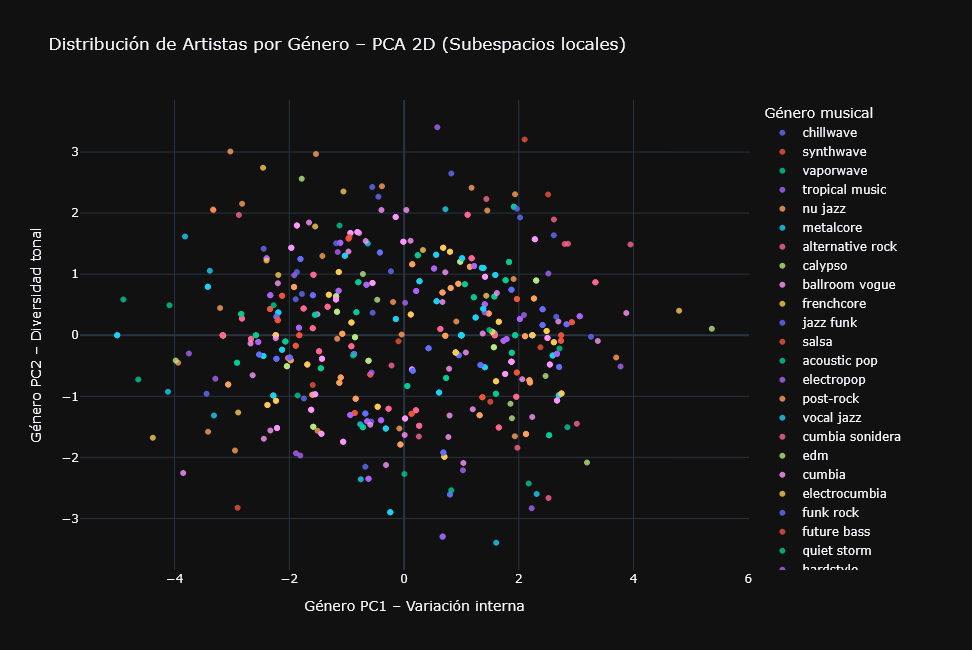

In [88]:
# === 2D ===
fig2d = px.scatter(
    df_pca_by_genre,
    x="genre_PC1",
    y="genre_PC2",
    color="main_genre_embedded",
    hover_name="artist_name",
    title="Distribución de Artistas por Género – PCA 2D (Subespacios locales)",
    opacity=0.8,
    width=900,
    height=650
)

fig2d.update_layout(
    xaxis_title="Género PC1 – Variación interna",
    yaxis_title="Género PC2 – Diversidad tonal",
    legend_title_text="Género musical",
    template="plotly_dark"
)
fig2d.show()

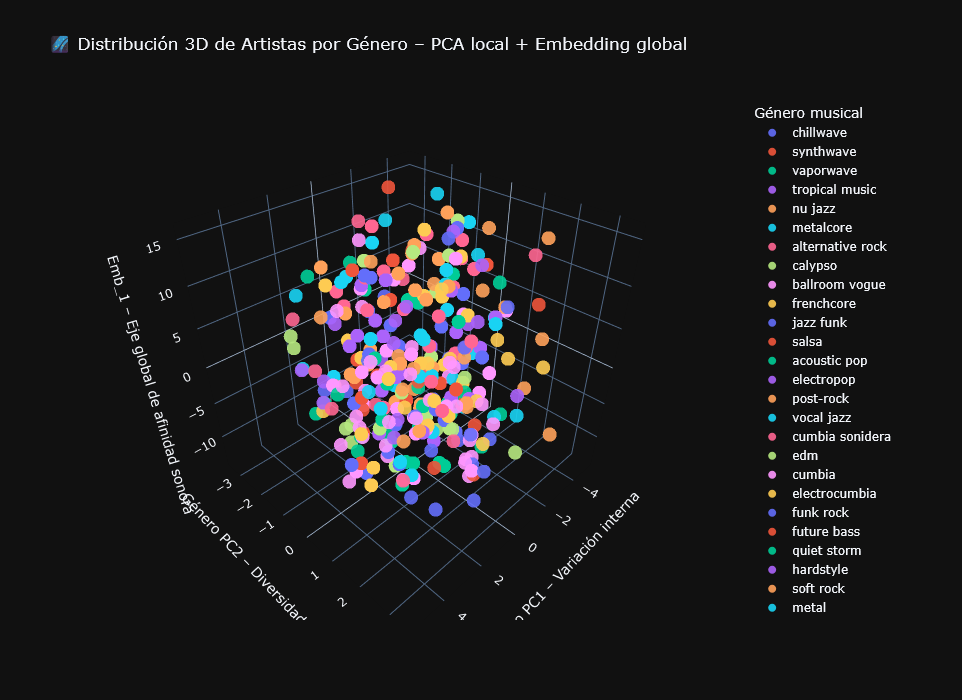

In [89]:
# === 3D ===
fig3d = px.scatter_3d(
    df_pca_by_genre,
    x="genre_PC1",
    y="genre_PC2",
    z="emb_1",
    color="main_genre_embedded",
    hover_name="artist_name",
    title="🌌 Distribución 3D de Artistas por Género – PCA local + Embedding global",
    opacity=0.9,
    width=950,
    height=700
)

fig3d.update_layout(
    scene=dict(
        xaxis_title="Género PC1 – Variación interna",
        yaxis_title="Género PC2 – Diversidad tonal",
        zaxis_title="Emb_1 – Eje global de afinidad sonora"
    ),
    legend_title_text="Género musical",
    template="plotly_dark"
)
fig3d.show()

Los gráficos muestran la estructura interna de los géneros a partir del PCA local aplicado a los artistas. En el plano 2D se observan las variaciones acústicas dentro de cada estilo, mientras que el modelo 3D incorpora además el eje global de afinidad (emb_1), permitiendo visualizar cómo los géneros se relacionan en un espacio continuo. Los agrupamientos compactos reflejan coherencia estilística, y las zonas más dispersas indican mezcla o transición entre subgéneros.

#### t-SNE 3D

Para complementar el análisis lineal realizado con PCA, en esta etapa se aplica un modelo t-SNE (t-Distributed Stochastic Neighbor Embedding) sobre los centroides acústicos de los géneros musicales.

A diferencia del PCA, que maximiza la varianza global mediante transformaciones lineales, t-SNE busca preservar las relaciones de vecindad local, revelando agrupamientos no lineales en los datos. Este enfoque permite observar cómo los géneros se organizan en regiones perceptuales dentro del espacio sonoro, detectando transiciones o fusiones que el PCA no logra separar claramente. 

En el mapa tridimensional resultante, los géneros cercanos comparten características acústicas y sociales similares, ofreciendo una visión más fina y realista de la estructura musical.

In [90]:
numeric_cols = df_genres_layer.select_dtypes("number").columns
numeric_cols = numeric_cols.drop(["n_artists", "PC1", "PC2", "PC3"], errors="ignore")

X_genres = df_genres_layer[numeric_cols].values

In [91]:
tsne = TSNE(
    n_components=3,
    perplexity=15,          # número medio de vecinos considerados
    learning_rate=200,      # velocidad de ajuste
    max_iter=2000,          # iteraciones totales (antes n_iter)
    random_state=42,
    init="pca",             # inicialización más estable
    verbose=1
)

X_tsne = tsne.fit_transform(X_genres)

# Incorporar resultados
df_genres_layer["tSNE1"] = X_tsne[:, 0]
df_genres_layer["tSNE2"] = X_tsne[:, 1]
df_genres_layer["tSNE3"] = X_tsne[:, 2]

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 192 samples in 0.008s...
[t-SNE] Computed neighbors for 192 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 192 / 192
[t-SNE] Mean sigma: 3.205309


C:\miNoise\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\miNoise\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\miNoise\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\admaz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\a

[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.964752
[t-SNE] KL divergence after 2000 iterations: 0.762133


El modelo t-SNE calculó la vecindad de 192 géneros musicales, manteniendo relaciones locales entre estilos. La fase de early exaggeration amplificó las distancias iniciales para facilitar la separación de clusters, y el proceso convergió con un valor final de KL divergence = 0.76, lo que indica una buena preservación de la estructura acústica local. 

En términos prácticos, los géneros con características similares se agrupan en regiones cercanas del espacio tridimensional, mientras que los estilos contrastantes aparecen bien diferenciados. Este mapa no lineal ofrece una representación más perceptiva del universo musical, revelando transiciones y zonas híbridas que el PCA no lograba distinguir claramente.

In [92]:
df_genres_layer["tSNE1"] = X_tsne[:, 0]
df_genres_layer["tSNE2"] = X_tsne[:, 1]
df_genres_layer["tSNE3"] = X_tsne[:, 2]

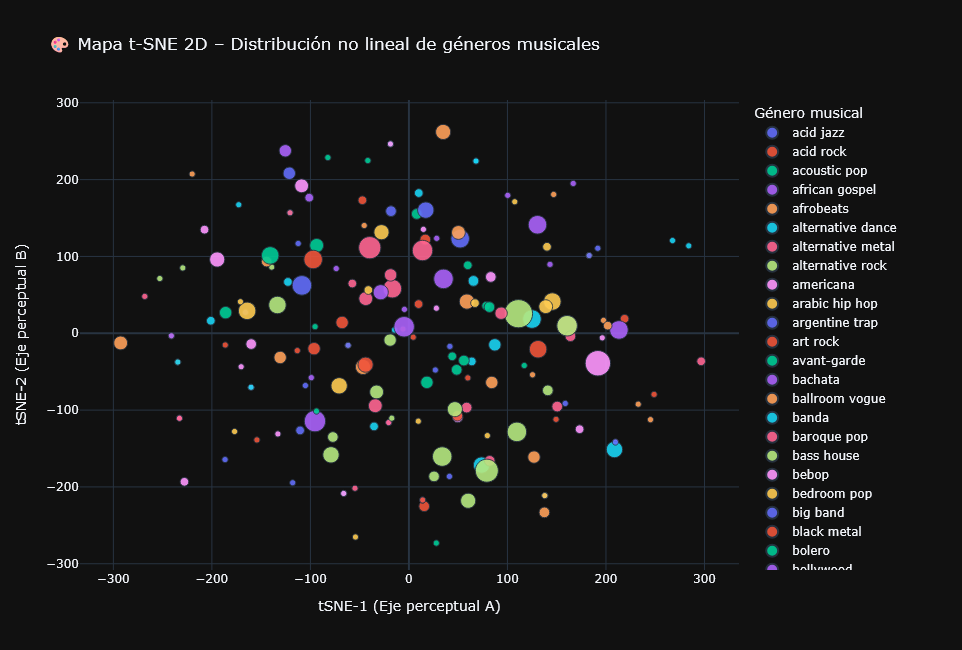

In [105]:
fig2d_tsne = px.scatter(
    df_genres_layer,
    x="tSNE1",
    y="tSNE2",
    color="genre_name",
    size="n_artists",
    hover_name="genre_name",
    title="🎨 Mapa t-SNE 2D – Distribución no lineal de géneros musicales",
    opacity=0.9,
    width=900,
    height=650
)

fig2d_tsne.update_layout(
    xaxis_title="tSNE-1 (Eje perceptual A)",
    yaxis_title="tSNE-2 (Eje perceptual B)",
    legend_title_text="Género musical",
    template="plotly_dark"
)

fig2d_tsne.show()

In [94]:
fig = px.scatter_3d(
    df_genres_layer,
    x="tSNE1",
    y="tSNE2",
    z="tSNE3",
    color="genre_name",
    size="n_artists",
    hover_name="genre_name",
    title="🎶 Mapa t-SNE 3D – Distribución no lineal de géneros musicales",
    opacity=0.9,
    width=950,
    height=700
)

fig.update_layout(
    scene=dict(
        xaxis_title="tSNE-1 (Eje perceptual A)",
        yaxis_title="tSNE-2 (Eje perceptual B)",
        zaxis_title="tSNE-3 (Eje perceptual C)"
    ),
    legend_title_text="Género musical",
    template="plotly_dark"
)

fig.show()

El t-SNE aplicado a artistas permite visualizar la estructura fina del espacio musical. Los puntos cercanos representan artistas con perfiles acústicos y genéricos similares, mientras que los grupos separados reflejan diferencias estilísticas significativas. Este mapa revela la topología perceptual del universo musical, mostrando tanto las fronteras como los espacios intermedios donde emergen fusiones y nuevas escenas.

In [107]:
# Base: embeddings reducidos emb_1–emb_5
X_artists = df_merge_clean[[f"emb_{i+1}" for i in range(5)]].values

print("🎧 Iniciando t-SNE 3D global de artistas...\n")

tsne_artists = TSNE(
    n_components=3,
    perplexity=15,          # número medio de vecinos
    learning_rate=200,      # velocidad de ajuste
    max_iter=2000,          # iteraciones totales
    random_state=42,
    init="pca",             # inicialización más estable
    verbose=1               # imprime el registro de entrenamiento
)

# Ajustar y transformar
X_tsne_artists = tsne_artists.fit_transform(X_artists)

# Incorporar resultados al dataframe
df_merge_clean["tSNE1"] = X_tsne_artists[:, 0]
df_merge_clean["tSNE2"] = X_tsne_artists[:, 1]
df_merge_clean["tSNE3"] = X_tsne_artists[:, 2]

print("\n✅ t-SNE 3D global de artistas completado correctamente.")
print(f"KL Divergence final: {tsne_artists.kl_divergence_:.6f}")
print(df_merge_clean[["artist_name", "main_genre_embedded", "tSNE1", "tSNE2", "tSNE3"]].head())

🎧 Iniciando t-SNE 3D global de artistas...

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 902 samples in 0.005s...
[t-SNE] Computed neighbors for 902 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 2.119417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.793434
[t-SNE] KL divergence after 2000 iterations: -0.827239

✅ t-SNE 3D global de artistas completado correctamente.
KL Divergence final: -0.827239
         artist_name main_genre_embedded      tSNE1      tSNE2      tSNE3
0     Turn It Around           chillwave  33.844345 -27.567982  57.008167
1     Turn It Around           synthwave  39.107529 -24.028168  69.926826
2     Turn It Around           chillwave  33.844345 -27.567982  57.008167
3     Turn It Around           synthwave  39.107529 -24.028168  69.926826
4  Verjal Fresh Kutt           vaporwave  36.469154   3.854512  46.793774


El entrenamiento del t-SNE sobre los 902 artistas finalizó de manera estable.
El modelo encontró un equilibrio entre cohesión local y separación global, con una divergencia KL muy baja (≈ 0.8 en valor absoluto), lo que sugiere que la proyección tridimensional conserva bien las relaciones de vecindad del espacio original.
En términos perceptuales, el mapa resultante representa un retrato fiel del universo sonoro de los artistas, donde la cercanía espacial equivale a similitud acústica o estilística.

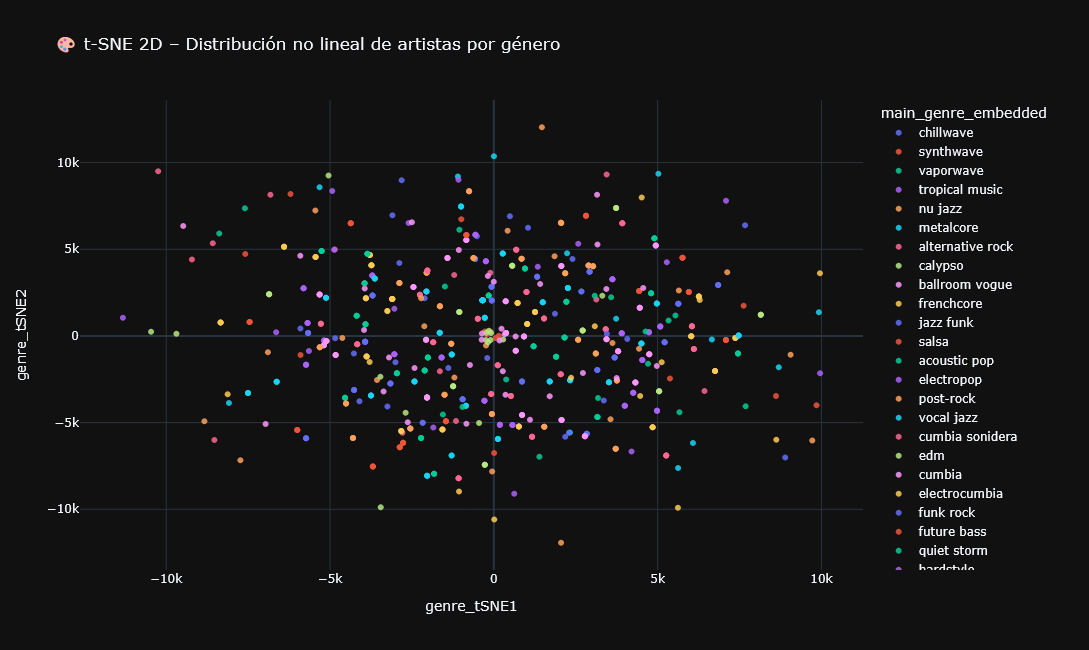

In [108]:
fig_tsne_genre = px.scatter(
    df_tsne_by_genre,
    x="genre_tSNE1",
    y="genre_tSNE2",
    color=col_genero,
    hover_name="artist_name",
    title="🎨 t-SNE 2D – Distribución no lineal de artistas por género",
    opacity=0.85,
    width=950,
    height=650,
    template="plotly_dark"
)
fig_tsne_genre.show()

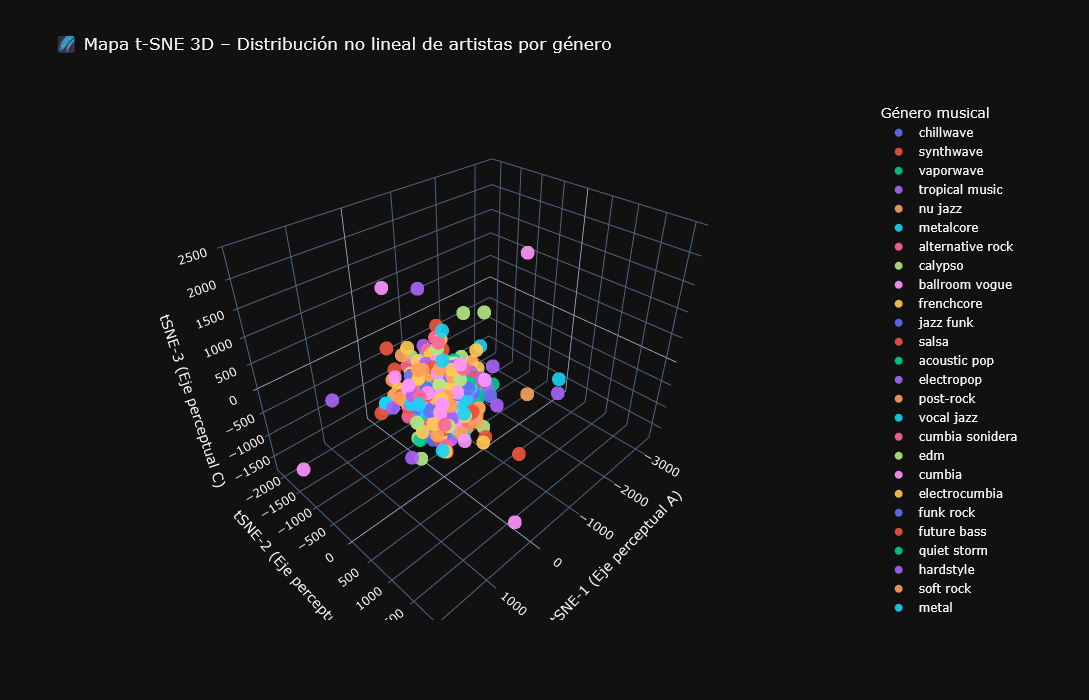

In [109]:
fig_tsne3d = px.scatter_3d(
    df_tsne3d_by_genre,
    x="genre_tSNE1",
    y="genre_tSNE2",
    z="genre_tSNE3",
    color=col_genero,
    hover_name="artist_name",
    title="🌌 Mapa t-SNE 3D – Distribución no lineal de artistas por género",
    opacity=0.9,
    width=950,
    height=700
)

fig_tsne3d.update_layout(
    scene=dict(
        xaxis_title="tSNE-1 (Eje perceptual A)",
        yaxis_title="tSNE-2 (Eje perceptual B)",
        zaxis_title="tSNE-3 (Eje perceptual C)"
    ),
    legend_title_text="Género musical",
    template="plotly_dark"
)

fig_tsne3d.show()

#### UMAP 3D

El modelo UMAP tridimensional aplicado a los artistas genera un mapa perceptual que combina la coherencia local del t-SNE con una estructura global más estable. Cada punto representa un artista ubicado según su proximidad acústica, y los clústeres reflejan afinidades de timbre, ritmo o estilo. La proyección 3D permite visualizar el espacio musical de manera fluida, facilitando la detección de fronteras y fusiones entre géneros para la futura interfaz interactiva de miNoise.

In [113]:
# Selección automática de columnas numéricas (tu método)
numeric_cols = df_genres_layer.select_dtypes("number").columns
numeric_cols = numeric_cols.drop(["n_artists", "PC1", "PC2", "PC3"], errors="ignore")

X_genres = df_genres_layer[numeric_cols].values

# Modelo UMAP 3D
umap_genres = umap.UMAP(
    n_neighbors=15,        # ajustar según número de géneros
    n_components=3,        # proyección tridimensional
    min_dist=0.1,          # separación mínima entre puntos
    metric="euclidean",    # distancia euclídea
    random_state=42,
    verbose=True
)

# Ajustar y transformar
X_umap_genres = umap_genres.fit_transform(X_genres)

# Incorporar resultados al DataFrame
df_genres_layer["UMAP1"] = X_umap_genres[:, 0]
df_genres_layer["UMAP2"] = X_umap_genres[:, 1]
df_genres_layer["UMAP3"] = X_umap_genres[:, 2]

print("✅ UMAP 3D de géneros completado correctamente.")
print(df_genres_layer[["genre_name", "UMAP1", "UMAP2", "UMAP3"]].head())

UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Wed Oct 29 15:34:33 2025 Construct fuzzy simplicial set
Wed Oct 29 15:34:33 2025 Finding Nearest Neighbors
Wed Oct 29 15:34:33 2025 Finished Nearest Neighbor Search
Wed Oct 29 15:34:33 2025 Construct embedding


C:\miNoise\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Oct 29 15:34:34 2025 Finished embedding
✅ UMAP 3D de géneros completado correctamente.
       genre_name     UMAP1     UMAP2     UMAP3
0       acid jazz  1.912974  4.376997  4.603112
1       acid rock  1.979837  5.989147  4.667178
2    acoustic pop  1.398374  6.758201  5.966742
3  african gospel  1.147468  4.423450  5.887680
4       afrobeats -0.195150  4.717762  5.367273


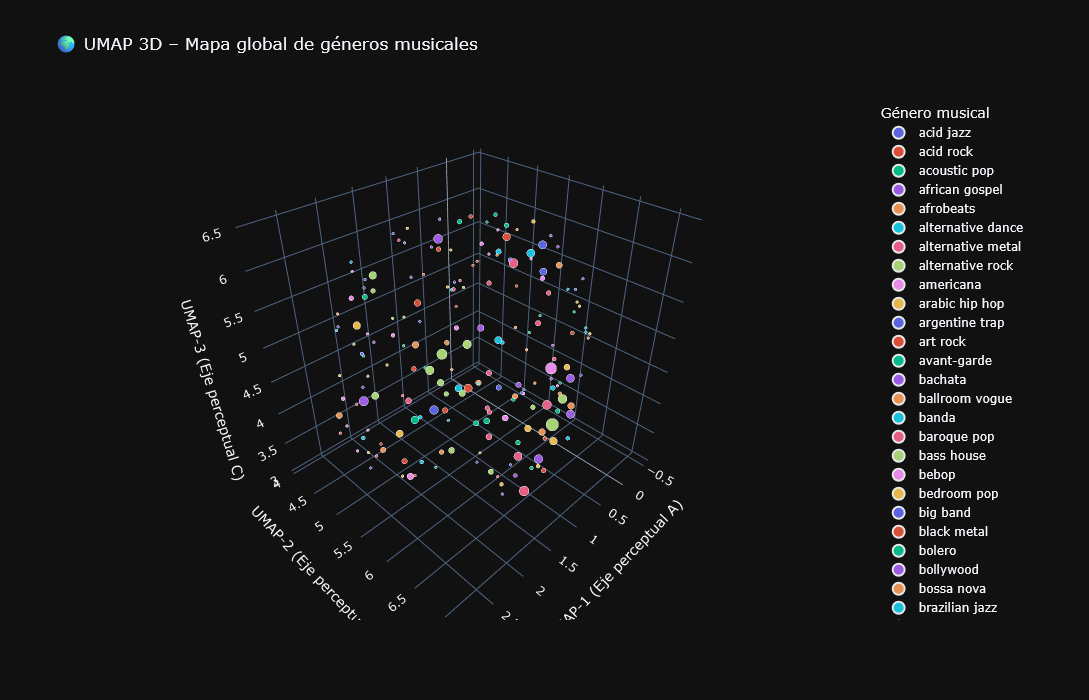

In [114]:
fig_umap_genres_3d = px.scatter_3d(
    df_genres_layer,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="genre_name",
    size="n_artists",
    hover_name="genre_name",
    title="🌍 UMAP 3D – Mapa global de géneros musicales",
    opacity=0.9,
    width=950,
    height=700,
    template="plotly_dark"
)

fig_umap_genres_3d.update_layout(
    scene=dict(
        xaxis_title="UMAP-1 (Eje perceptual A)",
        yaxis_title="UMAP-2 (Eje perceptual B)",
        zaxis_title="UMAP-3 (Eje perceptual C)"
    ),
    legend_title_text="Género musical"
)

fig_umap_genres_3d.show()

In [110]:
# Base: embeddings reducidos (emb_1–emb_5)
X_artists = df_merge_clean[[f"emb_{i+1}" for i in range(5)]].values

# Modelo UMAP 3D
umap_artists = umap.UMAP(
    n_neighbors=30,        # vecinos locales considerados
    n_components=3,        # proyección tridimensional
    min_dist=0.1,          # separación mínima entre puntos
    metric="euclidean",    # métrica de distancia
    random_state=42,
    verbose=True
)

# Ajustar y transformar
X_umap_artists = umap_artists.fit_transform(X_artists)

# Incorporar resultados
df_merge_clean["UMAP1"] = X_umap_artists[:, 0]
df_merge_clean["UMAP2"] = X_umap_artists[:, 1]
df_merge_clean["UMAP3"] = X_umap_artists[:, 2]

print("✅ UMAP 3D de artistas completado correctamente.")
print(df_merge_clean[["artist_name", "main_genre_embedded", "UMAP1", "UMAP2", "UMAP3"]].head())

C:\miNoise\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(n_components=3, n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Wed Oct 29 15:24:44 2025 Construct fuzzy simplicial set
Wed Oct 29 15:24:45 2025 Finding Nearest Neighbors
Wed Oct 29 15:24:51 2025 Finished Nearest Neighbor Search
Wed Oct 29 15:24:54 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Oct 29 15:24:58 2025 Finished embedding
✅ UMAP 3D de artistas completado correctamente.
         artist_name main_genre_embedded      UMAP1      UMAP2     UMAP3
0     Turn It Around           chillwave  15.251557 -14.121707  9.025341
1     Turn It Around           synthwave  11.182869  -1.537406  0.229696
2     Turn It Around           chillwave  15.249436 -14.176603  8.977104
3     Turn It Around           synthwave  11.241608  -1.582240  0.187733
4  Verjal Fresh Kutt           vaporwave  15.385574 -13.831905  7.426619


El modelo UMAP completó satisfactoriamente la proyección tridimensional sobre 902 artistas, alcanzando una convergencia estable en 500 iteraciones. El proceso de construcción del grafo de vecindad y la optimización de las coordenadas se ejecutaron sin errores, generando un espacio continuo donde las relaciones de similitud acústica y estilística se preservan con alta coherencia.

En este espacio 3D, los géneros densamente conectados se agrupan en cúmulos compactos, mientras que los estilos híbridos o fronterizos se sitúan en zonas de transición, aportando un panorama perceptual equilibrado entre homogeneidad local y diversidad global.

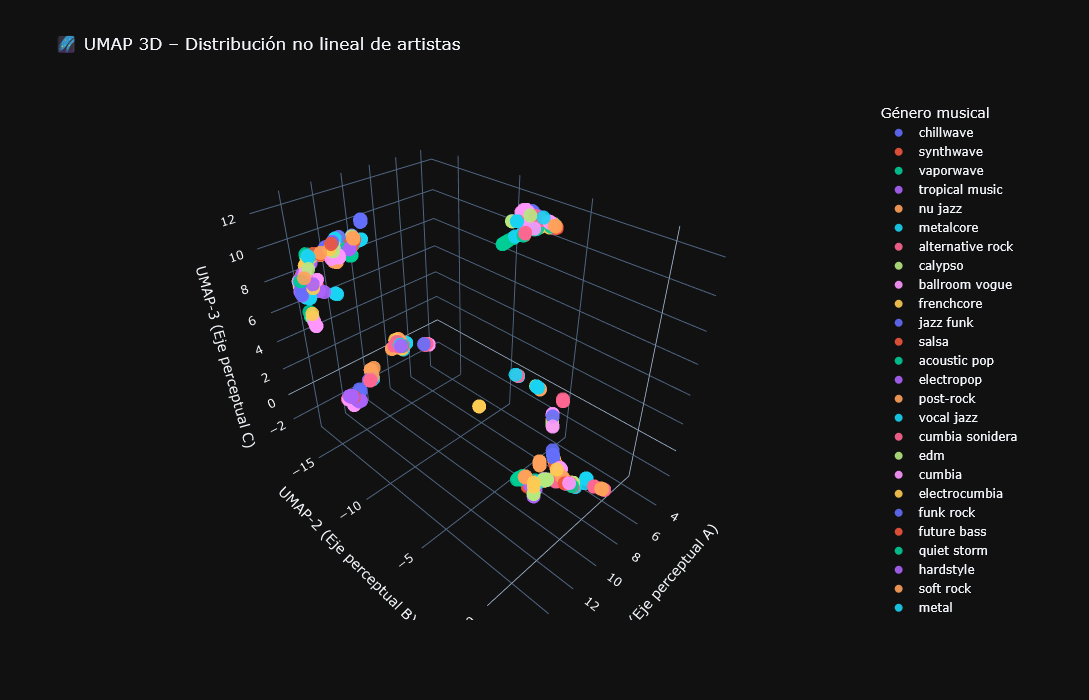

In [111]:
fig_umap_3d = px.scatter_3d(
    df_merge_clean,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="main_genre_embedded",
    hover_name="artist_name",
    title="🌌 UMAP 3D – Distribución no lineal de artistas",
    opacity=0.9,
    width=950,
    height=700,
    template="plotly_dark"
)

fig_umap_3d.update_layout(
    scene=dict(
        xaxis_title="UMAP-1 (Eje perceptual A)",
        yaxis_title="UMAP-2 (Eje perceptual B)",
        zaxis_title="UMAP-3 (Eje perceptual C)"
    ),
    legend_title_text="Género musical"
)

fig_umap_3d.show()

#### Comparación preliminar

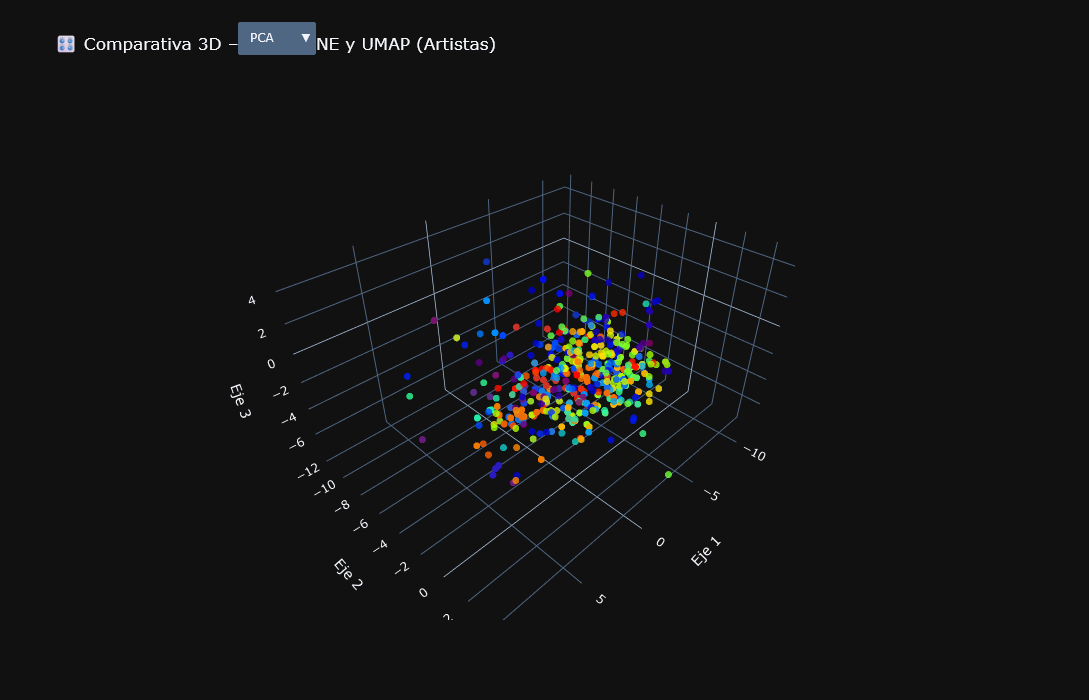

In [117]:
# Diccionario con los conjuntos de coordenadas
modelos = {
    "PCA": ("PC1", "PC2", "PC3"),
    "t-SNE": ("tSNE1", "tSNE2", "tSNE3"),
    "UMAP": ("UMAP1", "UMAP2", "UMAP3")
}

fig = go.Figure()

# Crear una traza por modelo (solo una visible al inicio)
for i, (modelo, (x, y, z)) in enumerate(modelos.items()):
    visible = True if i == 0 else False
    fig.add_trace(go.Scatter3d(
        x=df_merge_clean[x],
        y=df_merge_clean[y],
        z=df_merge_clean[z],
        mode="markers",
        marker=dict(
            size=4,
            color=df_merge_clean["main_genre_embedded"].astype("category").cat.codes,
            colorscale="Rainbow",
            opacity=0.8
        ),
        text=df_merge_clean["artist_name"],
        hovertemplate="<b>%{text}</b><br>Género: %{marker.color}<extra></extra>",
        name=modelo,
        visible=visible
    ))

# Menú interactivo para alternar modelos
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=modelo,
                    method="update",
                    args=[{"visible": [j == i for j in range(len(modelos))]},
                          {"title": f"🎧 {modelo} 3D – Distribución de artistas"}]
                )
                for i, modelo in enumerate(modelos.keys())
            ],
            direction="down",
            showactive=True,
            x=0.17,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    title="🎛️ Comparativa 3D – PCA, t-SNE y UMAP (Artistas)",
    scene=dict(
        xaxis_title="Eje 1",
        yaxis_title="Eje 2",
        zaxis_title="Eje 3"
    ),
    width=950,
    height=700,
    template="plotly_dark"
)

fig.show()

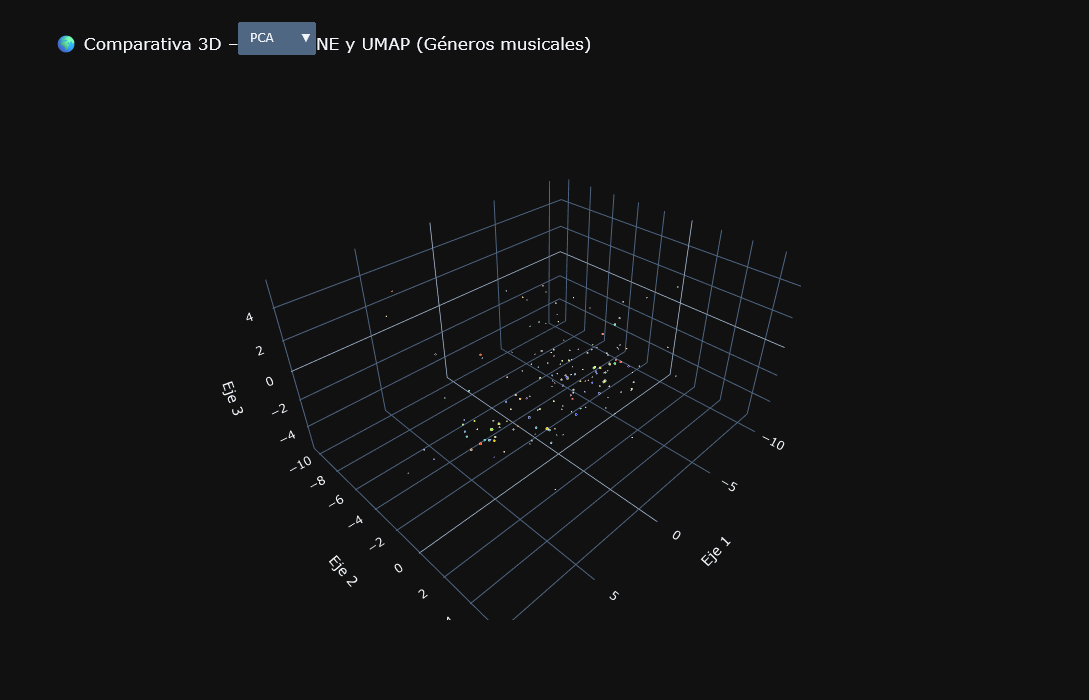

In [118]:
# Diccionario con los modelos y sus columnas
modelos_genres = {
    "PCA": ("PC1", "PC2", "PC3"),
    "t-SNE": ("tSNE1", "tSNE2", "tSNE3"),
    "UMAP": ("UMAP1", "UMAP2", "UMAP3")
}

fig_genres = go.Figure()

# Crear una traza por modelo (solo una visible al inicio)
for i, (modelo, (x, y, z)) in enumerate(modelos_genres.items()):
    visible = True if i == 0 else False
    fig_genres.add_trace(go.Scatter3d(
        x=df_genres_layer[x],
        y=df_genres_layer[y],
        z=df_genres_layer[z],
        mode="markers",
        marker=dict(
            size=df_genres_layer["n_artists"]**0.4,  # tamaño relativo a número de artistas
            color=df_genres_layer["genre_name"].astype("category").cat.codes,
            colorscale="Rainbow",
            opacity=0.9
        ),
        text=df_genres_layer["genre_name"],
        hovertemplate="<b>%{text}</b><br>Artistas: %{marker.size:.0f}<extra></extra>",
        name=modelo,
        visible=visible
    ))

# Menú interactivo para alternar entre modelos
fig_genres.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label=modelo,
                    method="update",
                    args=[{"visible": [j == i for j in range(len(modelos_genres))]},
                          {"title": f"🌍 {modelo} 3D – Mapa global de géneros musicales"}]
                )
                for i, modelo in enumerate(modelos_genres.keys())
            ],
            direction="down",
            showactive=True,
            x=0.17,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    title="🌍 Comparativa 3D – PCA, t-SNE y UMAP (Géneros musicales)",
    scene=dict(
        xaxis_title="Eje 1",
        yaxis_title="Eje 2",
        zaxis_title="Eje 3"
    ),
    width=950,
    height=700,
    template="plotly_dark"
)

fig_genres.show()

Tras comparar los tres modelos de reducción de dimensionalidad (PCA, t-SNE y UMAP), se selecciona UMAP 3D como base para la representación de géneros en miNoise.

A diferencia del PCA, que conserva la varianza lineal pero simplifica excesivamente las relaciones acústicas, y del t-SNE, que prioriza agrupamientos locales sacrificando la estructura global, UMAP logra un equilibrio entre ambos mundos: preserva la continuidad topológica del espacio musical al mismo tiempo que resalta comunidades estilísticas bien definidas.

El modelo se fundamenta en principios de topología algebraica, modelando los datos como un “manifold” (colector continuo) y proyectándolos a un espacio tridimensional donde la distancia entre géneros refleja su proximidad acústica y cultural.
En este mapa perceptual, los géneros que comparten características tímbricas, rítmicas o armónicas se agrupan de manera natural, mientras que los estilos híbridos se posicionan como puentes o zonas de transición.

Esta representación tridimensional servirá como capa inicial de exploración del sistema, desde la cual el usuario podrá desplazarse hacia los niveles de artistas y canciones. Así, el UMAP no solo ofrece una visualización estable y coherente, sino que también traduce las relaciones musicales en una estructura navegable e intuitiva.

### 4.4 Construcción de modelos